## Configuration and LLM scraping

In [1]:
!pip install -q \
  beautifulsoup4 \
  requests \
  playwright \
  langchain \
  langchain-openai \
  tiktoken \
  python-dateutil

In [2]:
!pip install -q langchain_huggingface

In [3]:
!apt-get update -qq
!apt-get install -y -qq \
    libatk-bridge2.0-0 \
    libatk1.0-0 \
    libcups2 \
    libdrm2 \
    libxkbcommon0 \
    libxcomposite1 \
    libxdamage1 \
    libxfixes3 \
    libxrandr2 \
    libgbm1 \
    libgtk-3-0 \
    libasound2

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [4]:
!playwright install chromium --force

In [5]:
!pip install -q nest_asyncio

In [6]:
from getpass import getpass
import os

if "HF_API_KEY" not in os.environ:
    os.environ["HF_API_KEY"] = getpass("Enter HuggingFace API key:")

Enter HuggingFace API key:··········


In [7]:
import nest_asyncio
nest_asyncio.apply()

In [8]:
import asyncio
import requests
from playwright.async_api import async_playwright

async def fetch_page(url, timeout=15):
    # Try requests first (fast)
    try:
        r = requests.get(
            url,
            timeout=timeout,
            headers={"User-Agent": "Mozilla/5.0"}
        )
        print(f"Request output: {r}")
        if r.status_code == 200 and len(r.text) > 1000:
            return r.text, "requests"
    except Exception as e:
        print(f"Failed to get request: {e}")
        pass

    # Fallback: Async Playwright
    try:
        async with async_playwright() as p:
            browser = await p.chromium.launch(headless=True)
            page = await browser.new_page()
            await page.goto(url, timeout=timeout * 1000)
            html = await page.content()
            await browser.close()
            return html, "playwright"
    except Exception as e:
        print(f"Failed to launch chromium: {e}")
        return None, None


In [9]:
from bs4 import BeautifulSoup

def extract_text(html):
    soup = BeautifulSoup(html, "html.parser")

    # Remove scripts/styles
    for tag in soup(["script", "style", "noscript"]):
        tag.decompose()

    text = soup.get_text(separator=" ")
    return " ".join(text.split())

In [17]:
from datetime import datetime

async def scrape_jobs(urls):
    results = []

    for url in urls:
        print(f"Scraping: {url}")

        html, method = await fetch_page(url)
        if not html:
            results.append({
                "job_id": "",
                "company": "",
                "role": "",
                "required_experience": "",
                "required_skills": [],
                "job_keywords": [],
                "location": "",
                "employment_type": "",
                "description": "",
                "source_url": url,
                "status": "inaccessible",
                "scraped_at": datetime.utcnow().isoformat()
            })
            continue

        text = extract_text(html)
        job_json = extract_job_json(text, url)
        results.append(job_json)

    return results

In [18]:
from huggingface_hub import InferenceClient
from datetime import datetime
import json
import os

client = InferenceClient(
    api_key=os.environ["HF_API_KEY"],  # Handles Nebius routing
    # provider="nebius"  # Explicit provider
)

def format_chat_messages(text, url):
    timestamp = datetime.utcnow().isoformat()

    # Use f-string - NO .format() needed for literal JSON schema
    system_content = f"""You are an information extraction agent.

Given the raw text of a webpage, extract job posting information.

If the page does not contain a job posting or is removed:
- set status = "removed"
- leave other fields empty

Extract ALL information including skills.

EXAMPLE 1:
Text: "Looking for Python, TensorFlow, NLP experience..."
Output: {{"required_skills": ["Python", "TensorFlow", "NLP"]}}

EXAMPLE 2:
Text: "Must have AWS, Docker, Kubernetes..."
Output: {{"required_skills": ["AWS", "Docker", "Kubernetes"]}}

CRITICAL: Never leave skills empty if mentioned. Look for: programming languages, frameworks, tools, methodologies, certifications.

Return ONLY valid JSON in this exact schema:
{{
  "job_id": "",
  "company": "",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "{url}",
  "status": "active | removed | inaccessible",
  "scraped_at": "{timestamp}"
}}

Webpage text:"""

    messages = [
        {"role": "system", "content": system_content},
        {"role": "user", "content": text}
    ]
    return messages

def safe_json_parse(content: str) -> dict:
    import re
    if not content:
        return {"status": "inaccessible", "error": "empty_response"}

    # Remove ```json and ``` markdown fences + extra whitespace
    content = re.sub(r'```json\s*|\s*```', '', content.strip())

    try:
        return json.loads(content)
    except json.JSONDecodeError as e:
        return {"status": "inaccessible", "error": f"parse_failed: {str(e)}"}

def extract_job_json(page_text, url):
    messages = format_chat_messages(page_text, url)
    completion = client.chat.completions.create(
        model="Qwen/Qwen2.5-7B-Instruct",
        messages=messages,
        #max_tokens=1024,
        #temperature=0.1
    )
    response_content = completion.choices[0].message.content
    print(response_content)
    return safe_json_parse(response_content)


In [10]:
!pip install pandas -q

In [11]:
import pandas as pd
df = pd.read_csv("Candidaturas.csv")
df.head()

,URL,Company,Statut,Last Update,CV,Cover Letter,Location,Observation
0,https://meltwatercareers.ttcportals.com/jobs/1...,Meltwater,Archived,6 de janeiro de 2026 14:11,CV_ROCHA_Caio_Meltwater.pdf,Meltwater_Cover_Letter.pdf,"Paris, Ilha-de-França, França",NaN
1,https://careers.abbvie.com/en/job/ai-and-machi...,AbbVie,Rejected,6 de janeiro de 2026 14:11,NaN,NaN,"Paris, Ilha-de-França, França",NaN
2,https://scientalab.welcomekit.co/jobs/machine-...,https://scientalab.welcomekit.co/jobs/machine-...,Rejected,6 de janeiro de 2026 14:11,CV_ROCHA_Caio_Scienta.pdf,NaN,"Paris, Ilha-de-França, França",Contacter https://www.linkedin.com/in/vincent-...
3,https://careers.gehealthcare.com/global/en/job...,https://careers.gehealthcare.com/global/en/job...,Rejected,6 de janeiro de 2026 14:11,CV_ROCHA_Caio_GE.pdf,NaN,"Buc, Ilha-de-França, França",Wednesday 9/24 9 a.m.
4,https://www.linkedin.com/jobs/view/4242647430/...,Algolia,Rejected,6 de janeiro de 2026 14:12,NaN,NaN,"Paris, Ilha-de-França, França",NaN


In [14]:
df["URL"][32]

'https://jobs.lever.co/aqemia.com/f2587196-403d-41b3-87d5-b26ab217c8d2'

In [19]:
# urls = [
#     "https://meltwatercareers.ttcportals.com/jobs/16497508-machine-learning-engineer-nlp"
# ]

urls = df["URL"].tolist()[32:]

jobs = await scrape_jobs(urls)


Scraping: https://matera.recruitee.com/o/cdi-genai-engineer-paris
Request output: <Response [200]>


/tmp/ipython-input-1901427198.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{
  "job_id": "",
  "company": "Matera",
  "role": "GenAI Engineer",
  "required_experience": "3 ans",
  "required_skills": ["Python", "FastAPI", "Langchain", "Langgraph", "Langfuse", "Gemini", "Mistral", "OpenAI"],
  "job_keywords": ["GenAI", "Data Scientist", "Software Engineer", "LLMs", "Prompt engineering", "RAG", "agents"],
  "location": "Paris, Île-de-France, France",
  "employment_type": "CDI",
  "description": "Nous recherchons un·e GenAI Engineer pour renforcer notre équipe GenAI afin de développer des applications d'IA générative et optimiser nos opérations internes et améliorer notre produit. Tu intégreras l'équipe data (6 personnes) et collaboreras avec les équipes de développement produit et les équipes ops. Tes objectifs : développer des agents LLM les intégrer aux outils internes et les optimiser continuellement. Au programme : Développement de POCs pour identifier le potentiel des applications Mesure de la performance et optimisation des solutions Mise à disposition des

/tmp/ipython-input-1901427198.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()


{
  "job_id": "",
  "company": "Crédit Agricole",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "https://groupecreditagricole.jobs/fr/nos-offres-emploi/404--la-page-que-vous-recherchez-est-introuvable--",
  "status": "removed",
  "scraped_at": "2026-01-12T03:03:52.113503"
}
Scraping: https://www.welcometothejungle.com/fr/companies/locala/jobs/data-scientist_marseille_LOCAL_z7VgzA2
Request output: <Response [200]>
{
  "job_id": "",
  "company": "LOCALA",
  "role": "Data Scientist",
  "required_experience": "2 à 3 ans",
  "required_skills": ["Python", "Spark", "Java", "Scala", "IA générative", "deep learning", "clustering", "traitement de données géographiques"],
  "job_keywords": ["data science", "machine learning", "AI", "omnichannel advertising platform", "audience insights", "media strategies"],
  "location": "Marseille, France",
  "employment_type": "CDI",
  "d

HfHubHTTPError: 402 Client Error: Payment Required for url: https://router.huggingface.co/together/v1/chat/completions (Request ID: Root=1-696464a2-6453ad717a6226d665169bd9;ed2eb665-7b78-43be-82d3-ada79dc5864b)

You have reached the free monthly usage limit for together. Subscribe to PRO to get 20x more included usage, or add pre-paid credits to your account.

In [76]:
df["URL"].tolist()

['https://meltwatercareers.ttcportals.com/jobs/16497508-machine-learning-engineer-nlp',
 'https://careers.abbvie.com/en/job/ai-and-machine-learning-engineer-in-rungis-idf-jid-19583',
 'https://scientalab.welcomekit.co/jobs/machine-learning-engineer_paris_SL_W77OROl',
 'https://careers.gehealthcare.com/global/en/job/GEVGHLGLOBALR4028534EXTERNALENGLOBAL/Software-Engineer-en-technologies-web-et-IA-H-F?utm_source=linkedin&utm_medium=phenom-feeds',
 'https://www.linkedin.com/jobs/view/4242647430/?alternateChannel=search&eBP=CwEAAAGZTUFQBZAVhTvqutMrX4nlDBR78LXN24gGNf6TW72Yk1aQ8QTLOzaCgha0ooQliyewwRUIzqvlWfuLz4BVlT83oXAehinNS4Q6i-lTqsxWFpBD7g-zxLbgIq9oQ9tOwYFCx-6y-6jA1aI0YZVMD0eixfhGnHdJu4PBqqT8Vg6ogrqujBYW02gU5tmzGf4TPKzBGa-JfkQbK28YHhuaoTfixeHSl-eF1FJfqDlg5ykpxVlPpagt490SX5QUXLR-wZxkLY5pG6n_G8IZAD0-VNPzAHCDQewWSMD9aEoQuigzRpKLdOs4dNxWcDDxXz18HgPJrqGW51yTBzHioZ9ZRBSTuwRMUCM-C3r8fVDlEIUIBVOO4Z5PquSfVXWMlJ77f6ear1qh__MibzEeVVEcK5PAoqQG4xF5IFtueiwph9QuYRnW9zHy_gVJuiTvLhqgBD6g3dD8vfvON844w5Al1Wk

## Read raw outputs from previous runs


In [22]:
raw_output = '''Scraping: https://meltwatercareers.ttcportals.com/jobs/16497508-machine-learning-engineer-nlp
Request output: <Response [403]>
/tmp/ipython-input-2693973740.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()
{
  "job_id": "",
  "company": "Meltwater",
  "role": "Machine Learning Engineer (NLP)",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "https://meltwatercareers.ttcportals.com/jobs/16497508-machine-learning-engineer-nlp",
  "status": "inaccessible",
  "scraped_at": "2026-01-12T01:48:30.387660"
}

Scraping: https://careers.abbvie.com/en/job/ai-and-machine-learning-engineer-in-rungis-idf-jid-19583
Request output: <Response [200]>
```json
{
  "job_id": "R00133576",
  "company": "AbbVie",
  "role": "AI & Machine Learning Engineer",
  "required_experience": "",
  "required_skills": ["Python", "TensorFlow", "Machine learning", "AI solutions", "Kalman filter", "Robotics", "Object detection", "Cloud computing", "Containerization", "Docker", "Kubernetes", "Big data"] ,
  "job_keywords": [],
  "location": "Rungis, IDF",
  "employment_type": "Full-time",
  "description": "Model Deployment: deploy machine learning models into production environments, making them available for real-time inference and ensuring scalability and reliability. Model Development: Design, develop, and implement advanced analytics models, including, machine learning algorithms, and AI solutions. Collaboration: Collaborate with data scientists and data engineers to design and implement robust deployment pipelines for continuous improvement of machine learning models. Continuous Integration/Continuous Deployment (CI/CD): Implement and optimize CI/CD pipelines for machine learning models, automating testing and deployment processes. Monitoring and Logging : Set up monitoring and logging solutions to track model performance, system health, and anomalies, allowing for timely intervention and proactive maintenance.",
  "source_url": "https://careers.abbvie.com/en/job/ai-and-machine-learning-engineer-in-rungis-idf-jid-19583",
  "status": "removed",
  "scraped_at": "2026-01-12T01:48:32.578225"
}
```
Scraping: https://scientalab.welcomekit.co/jobs/machine-learning-engineer_paris_SL_W77OROl
Request output: <Response [404]>
/tmp/ipython-input-2693973740.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()
```json
{
  "job_id": "machine-learning-engineer_paris_SL_W77OROl",
  "company": "Scienta Lab",
  "role": "Machine Learning Engineer",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": ["Machine Learning", "Engineer"],
  "location": "Paris",
  "employment_type": "Full-Time",
  "description": "This position has been filled!",
  "source_url": "https://scientalab.welcomekit.co/jobs/machine-learning-engineer_paris_SL_W77OROl",
  "status": "removed",
  "scraped_at": "2023-01-12T01:48:38.451713"
}

```
Scraping: https://careers.gehealthcare.com/global/en/job/GEVGHLGLOBALR4028534EXTERNALENGLOBAL/Software-Engineer-en-technologies-web-et-IA-H-F?utm_source=linkedin&utm_medium=phenom-feeds
Request output: <Response [200]>
```json
{
  "job_id": "GEVGHLGLOBALR4028534EXTERNALENGLOBAL",
  "company": "GE HealthCare",
  "role": "Software Engineer",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": ["Software Engineer", "en technologies web et IA H/F", "Buc", "Yvelines"],
  "location": "Buc, Yvelines, France, 78533",
  "employment_type": "unknown",
  "description": "Unfortunately the job you're trying to apply for has been filled.\n\nMaybe you would like to reconsider the categories below:\n\nCareer Site Cookie Settings Personal Information",
  "source_url": "https://careers.gehealthcare.com/global/en/job/GEVGHLGLOBALR4028534EXTERNALENGLOBAL/Software-Engineer-en-technologies-web-et-IA-H-F?utm_source=linkedin&utm_medium=phenom-feeds",
  "status": "removed",
  "scraped_at": "2026-01-12T01:48:41.780402"
}
```

Scraping: https://www.linkedin.com/jobs/view/4242647430/?alternateChannel=search&eBP=CwEAAAGZTUFQBZAVhTvqutMrX4nlDBR78LXN24gGNf6TW72Yk1aQ8QTLOzaCgha0ooQliyewwRUIzqvlWfuLz4BVlT83oXAehinNS4Q6i-lTqsxWFpBD7g-zxLbgIq9oQ9tOwYFCx-6y-6jA1aI0YZVMD0eixfhGnHdJu4PBqqT8Vg6ogrqujBYW02gU5tmzGf4TPKzBGa-JfkQbK28YHhuaoTfixeHSl-eF1FJfqDlg5ykpxVlPpagt490SX5QUXLR-wZxkLY5pG6n_G8IZAD0-VNPzAHCDQewWSMD9aEoQuigzRpKLdOs4dNxWcDDxXz18HgPJrqGW51yTBzHioZ9ZRBSTuwRMUCM-C3r8fVDlEIUIBVOO4Z5PquSfVXWMlJ77f6ear1qh__MibzEeVVEcK5PAoqQG4xF5IFtueiwph9QuYRnW9zHy_gVJuiTvLhqgBD6g3dD8vfvON844w5Al1WkycyQXJEGzuLhxUhizJbqUep5kLh48W6BnuSmTbDxfx0N9WKxGrQ&refId=kl%2F5flDbsPbC25bIOomP8w%3D%3D&trackingId=CUhOIRVoQUNvPlztuRzI4Q%3D%3D&trk=d_flagship3_search_srp_jobs&lipi=urn%3Ali%3Apage%3Ad_flagship3_search_srp_jobs%3B59KE%2Fh4LSmqVHFeqDEJNtw%3D%3D
Request output: <Response [200]>
```json
{
  "job_id": "null",
  "company": "null",
  "role": "null",
  "required_experience": "null",
  "required_skills": ["null"],
  "job_keywords": ["Responsable Approvisionnement", "Procurement", "Supply Chain", "Purchasing", "Achats", "Logistique"],
  "location": "France",
  "employment_type": "null",
  "description": "null",
  "source_url": "https://www.linkedin.com/jobs/view/4242647430/?alternateChannel=search&eBP=CwEAAAGZTUFQAoNVjN94jkqL1NzEf3DFjAjCxnb3JJMNQS4k1Dc4NNlTjQVS5pRieW7c5kIWAzySzvNnTf3mHwkzZGAhCThgtHFZxNnNAd7Y%2BnVQfNltk%2F4yC9g1%2B8y%2Fb4aU9L9grOo%2F1i4%2FnQwGqM",
  "status": "active | removed | inaccessible",
  "scraped_at": "2026-01-12T01:48:45.596999"
}
```



Let's explain the key fields and how they were addressed in the generated JSON:

* **job_id, company, role, required_experience, required_skills, **job_keywords, **location, **employment_type, **description, **source_url**  The provided job data looks very similar to the abstract data provided.

* **status**: We set this to "active", "removed", or "inaccessible". These can be determined using the provided data.

* **scraped_at**:  This field was explicitly set, giving a documentation timestamp.

**Impressions:**

* The data you provided is incomplete. It appears to resemble a major portion of the LinkedIn Job Ads processing with claims that it can't generate "trained AI" yet.

*  The provided text partly indicates an investigation into a chatbot and AI model variations that processes web pages to enhance job posts, given the presence of LinkedIn job post links in the output.



Let me know how else I can help.
Scraping: https://naptha.ai/careers?ashby_jid=30c90b3a-8887-42be-9a84-921e08933ca6&utm_source=k3pN1XlLyX
Request output: <Response [200]>
```json
{
  "job_id": "n/a",
  "company": "Naptha AI",
  "role": "N/A",
  "required_experience": "N/A",
  "required_skills": [],
  "job_keywords": ["Open source", "AGI", "autonomous agents"],
  "location": "N/A",
  "employment_type": "N/A",
  "description": "N/A",
  "source_url": "https://naptha.ai/careers",
  "status": "active",
  "scraped_at": "2023-10-27T15:08:31.774825"
}
```


**Explanation:**

* **job_id:** Not present in this text.
* **company:** Naptha AI
* **role:** Not present in this text. The text talks about general positions at Naptha AI.
* **required_experience:** Not present in this text
* **required_skills:**  Skills like "open source" and "AGI" are mentioned. However, a precise skillset isn't given.
* **job_keywords:** The text includes "open source," and "AGI," search keywords. The associated keyword is "AGi".
* **location:** No location details are provided.
* **employment_type:** Not present.
* **description:** No description of  jobs are mentioned.
* **source_url:** The link to their careers page as the source URL.
* **status:** set to "active", as there are open postings on their site
* **scraped_at:**  October 27, 2023  at a time


It's important to note that this is based on a very limited part of the webpage.  The careers or job postings data are likely contained on a different section or page.




Scraping: https://jobs.lever.co/ogury/23363ee2-59e5-4860-b93d-cd4debc73c5f/
Request output: <Response [200]>
```json
{
  "job_id": "null",
  "company": "Ogury",
  "role": "null",
  "required_experience": "null",
  "required_skills": [],
  "job_keywords": [],
  "location": "Paris",
  "employment_type": "null",
  "description": "Ogury is a global adtech company that delivers Personified Advertising solutions grounded in privacy to brands, agencies and publishers by focusing on targeting personas, not people. We deliver relevant audiences at scale and on quality publisher inventory thanks to our exclusive data, which is meticulously collected and crafted from millions of self-declared customer surveys, enriched with billions of impactful data points, and refined by AI. This results in audience insights and performance not available through any other AdTech platform. Founded in 2014, Ogury is a global organization with a diverse team of 500+ people across 17 countries. At Ogury, our vision unites us all. But we know that it takes people from all walks of life to come together and make it happen. We embrace and celebrate what makes us different, creating a unique and winning culture where everyone feels safe, has access to the same opportunities, and is excited about bringing their most authentic self to work. Everyday. Together we’re changing the face of adtech with values that inspire excellence, standards that encourage a leadership mindset, and an inclusive workplace where Ogurians are engaged and know they belong. We may use artificial intelligence (AI) tools to support parts of the hiring process, such as reviewing applications, analyzing resumes, or assessing responses. These tools assist our recruitment team but do not replace human judgment. Final hiring decisions are ultimately made by humans. If you would like more information about how your data is processed, please contact us. ",
  "source_url": "https://www.ogury.com/careers/",
  "status": "removed",
  "scraped_at": "2026-01-12T01:48:53.155911"
}
```

Scraping: https://www.welcometothejungle.com/fr/companies/sifflet/jobs/applied-ml-ai-engineer-monitoring_paris
Request output: <Response [200]>
```json
{
  "job_id": null,
  "company": "Sifflet",
  "role": "ML/AI Engineer - Monitoring",
  "required_experience": "> 3 years",
  "required_skills": [
    "Python",
    "PyTorch"
  ],
  "job_keywords": [
    "data observability",
    "data quality",
    "data warehousing",
    "time series forecasting",
    "ML-based features",
    "natural language",
    "data profiling",
    "automated monitoring"
  ],
  "location": "Paris, France",
  "employment_type": "CDI",
  "description": "The monitoring team implements the foundational capabilities of Sifflet: detecting data quality issues across a wide range of data warehouses and databases. Sifflet’s monitoring capabilities rely heavily on machine learning (ML) techniques.  Most advanced data quality checks are based on time series forecasting models that detect unexpected distribution changes while accounting for seasonality and one-off events. Additionally, ML-based features are present throughout our product, be it for intelligent alert grouping, automated incident description, or automated monitor suggestions. As a machine learning engineer on the monitoring team, you will... ",
  "source_url": "https://www.welcometothejungle.com/fr/companies/sifflet/jobs/applied-ml-ai-engineer-monitoring_paris",
  "status": "removed",
  "scraped_at": "2026-01-12T01:48:56.712522"
}
```

Scraping: https://www.welcometothejungle.com/fr/companies/qantev/jobs/machine-learning-engineer_paris
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "Qantev",
  "role": "Machine Learning Engineer",
  "required_experience": "5+ years",
  "required_skills": ["PyTorch", "TensorFlow", "NLP", "Hugging Face", "Logistic Regression", "Image Classification", "Graph Neural Networks", "Experience with  healthcare or insurance ML", "Bayesian re-ranking",  "self-supervised learning", "agentic autoML",  "Model building, evaluation, model optimization", "MLOps", "Containerization", "Model Serving Pipelines", "CI/CD for ML", "Trained on datasets,  Clean and healthy data", "Effective work style", "Python", "SQL" ],
  "job_keywords": ["Machine Learning", "Deep Learning", "AI", "NLP", "Computer Vision",  "Fraud Detection", "Medical Code Inference", "Document Understanding", "Scalable Infrastructure", "Design", "Modeling", "Evaluation", "Continuous Learning", "Model Deployment", "Production Pipelines", "Collaboration", "MLOps", "Data Engineering"],
  "location": "Paris",
  "employment_type": "CDI",
  "description": "Shape Qantev’s next-generation AI models from information extraction to anomaly detection. Your work will power document understanding, medical code inference, and scalable fraud detection architectures.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/qantev/jobs/machine-learning-engineer_paris",
  "status": "removed",
  "scraped_at": "2026-01-12T01:48:59.701214"
}
```
Scraping: https://www.welcometothejungle.com/fr/companies/digeiz/jobs/deep-learning-engineer_boulogne-billancourt_DIGEI_N9K0XK7
Request output: <Response [200]>
```json
{
  "job_id": "DEEP-LEARNING-ENGINEER_BONNETANG",
  "company": "digeiz",
  "role": "Deep Learning Research Engineer",
  "required_experience": " > 3 years",
  "required_skills": [
    "deep learning",
    "computer vision",
    "object detection",
    "feature extraction",
    "image classification",
    "PyTorch",
    "TensorFlow",
    "Pandas",
    "Linear Algebra",
    "Statistics"
  ],
  "job_keywords": [],
  "location": "Boulogne-Billancourt, France",
  "employment_type": "CDI",
  "description": "We are opening a Deep Learning Engineer position to scale our GDPR-compliant outfit reidentification in the 25 malls across Europe and the ones coming in the US and Middle East. We are seeking candidates with advanced analytics skills and an academic background in a field linked to applied mathematics, statistics, machine learning, or other related fields. Your missions: Improve our detection and re-identification models by contributing to enhancing data collection , neural network architectures and training paradigms , pre/post-processing, and performance evaluation. Provide a bibliography on relevant computer vision projects and implement prototypes based on promising papers . Facilitate the deployment of R&D prototypes by closely collaborating with the software and operational teams.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/digeiz/jobs/deep-learning-engineer_boulogne-billancourt_DIGEI_N9K0XK7",
  "status": "removed",
  "scraped_at": "2026-01-12T01:49:02.935894"
}
```

Scraping: https://www.welcometothejungle.com/fr/companies/vusiongroup/jobs/ingenieur-ia-specialise-en-computer-vision_amiens
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "Human After All",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "https://www.welcometothejungle.com/",
  "status": "removed",
  "scraped_at": "2026-01-12T01:49:06.183865"
}
```
Scraping: Applied Scientist / Research Engineer - EMEA
Failed to get request: Invalid URL 'Applied Scientist / Research Engineer - EMEA': No scheme supplied. Perhaps you meant https://Applied Scientist / Research Engineer - EMEA?
Failed to launch chromium: Page.goto: Protocol error (Page.navigate): Cannot navigate to invalid URL
Call log:
  - navigating to "Applied Scientist / Research Engineer - EMEA", waiting until "load"

Scraping: AI Scientist - Paris/London - Onsite or Hybrid or Remote
Failed to get request: Invalid URL 'AI Scientist - Paris/London - Onsite or Hybrid or Remote': No scheme supplied. Perhaps you meant https://AI Scientist - Paris/London - Onsite or Hybrid or Remote?
/tmp/ipython-input-1387603912.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "scraped_at": datetime.utcnow().isoformat()
Failed to launch chromium: Page.goto: Protocol error (Page.navigate): Cannot navigate to invalid URL
Call log:
  - navigating to "AI Scientist - Paris/London - Onsite or Hybrid or Remote", waiting until "load"

Scraping: AI Scientist - Palo Alto
Failed to get request: Invalid URL 'AI Scientist - Palo Alto': No scheme supplied. Perhaps you meant https://AI Scientist - Palo Alto?
/tmp/ipython-input-1387603912.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "scraped_at": datetime.utcnow().isoformat()
Failed to launch chromium: Page.goto: Protocol error (Page.navigate): Cannot navigate to invalid URL
Call log:
  - navigating to "AI Scientist - Palo Alto", waiting until "load"

Scraping: Software Engineer - Robotics
Failed to get request: Invalid URL 'Software Engineer - Robotics': No scheme supplied. Perhaps you meant https://Software Engineer - Robotics?
/tmp/ipython-input-1387603912.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "scraped_at": datetime.utcnow().isoformat()
Failed to launch chromium: Page.goto: Protocol error (Page.navigate): Cannot navigate to invalid URL
Call log:
  - navigating to "Software Engineer - Robotics", waiting until "load"

Scraping: Ingénieur de recherche en deep learning
Failed to get request: Failed to parse: Ingénieur de recherche en deep learning
/tmp/ipython-input-1387603912.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "scraped_at": datetime.utcnow().isoformat()
Failed to launch chromium: Page.goto: Protocol error (Page.navigate): Cannot navigate to invalid URL
Call log:
  - navigating to "Ingénieur de recherche en deep learning", waiting until "load"

Scraping: Ingénieur(e) développement IA et Data
Failed to get request: Failed to parse: Ingénieur(e) développement IA et Data
/tmp/ipython-input-1387603912.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "scraped_at": datetime.utcnow().isoformat()
Failed to launch chromium: Page.goto: Protocol error (Page.navigate): Cannot navigate to invalid URL
Call log:
  - navigating to "Ingénieur(e) développement IA et Data", waiting until "load"

Scraping: R&D Data Scientist
Failed to get request: Invalid URL 'R&D Data Scientist': No scheme supplied. Perhaps you meant https://R&D Data Scientist?
/tmp/ipython-input-1387603912.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "scraped_at": datetime.utcnow().isoformat()
Failed to launch chromium: Page.goto: Protocol error (Page.navigate): Cannot navigate to invalid URL
Call log:
  - navigating to "R&D Data Scientist", waiting until "load"

Scraping: https://www.renaissancephilanthropy.org/careers/machine-learning-engineer
/tmp/ipython-input-1387603912.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "scraped_at": datetime.utcnow().isoformat()
Request output: <Response [200]>
/tmp/ipython-input-2693973740.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()
```json
{
  "job_id": "",
  "company": "Renaissance Philanthropy",
  "role": "Machine Learning Engineer",
  "required_experience": "Demonstrated experience building production-grade ML-enabled software in a commercial environment.",
  "required_skills": [
    "LLM evaluation",
    "agentic frameworks",
    "RAG",
    "AI",
    "NLP",
    "ML",
    "Cloud resources",
    "API creation and load testing"
  ],
  "job_keywords": ["Machine Learning", "AI", "ML", "LLM", "RAG", "agentic frameworks"],
  "location": "",
  "employment_type": "remote",
  "description": "Support teams in utilizing cloud resources, developing prototypes, and evaluating ML/AI systems to ensure quality and safety. Assist teams in writing technical documentation, conducting research and present findings.",
  "source_url": "https://www.renaissancephilanthropy.org/careers/machine-learning-engineer",
  "status": "active",
  "scraped_at": "2026-01-12T01:49:12.897530"
}
```
Scraping: https://jobs.atos.net/job/Clermont-Ferrand-Ing%C3%A9nieur-IA-FH/1247017301/?utm_campaign=WelcometotheJungle&utm_source=WelcometotheJungle&applySourceOverride=Welcome%20to%20the%20Jungle
Request output: <Response [200]>
```json
{
  "job_id": "535506",
  "company": "Atos",
  "role": "Ingénieur IA - F/H",
  "required_experience": "au moins 3 ans",
  "required_skills": [
    "algorithmes",
    "traitement de données",
    "NLP",
    "LLM",
    "RAG",
    "algorithmique",
    "statistique",
    "analyse de données",
    "data mining"
  ],
  "job_keywords": [
    "IA",
    "machine learning",
    "science des données",
    "polyisArray",
    "deep learning"
  ],
  "location": "Clermont-Ferrand",
  "employment_type": "full time",
  "description": "Tester et fine-tunner des modèles open source ; Concevoir et développer les systèmes de machine learning ; Analyser et interpréter des ensembles de données complexes ; Optimiser les performances des modèles existants et assurer leur maintenance ; Collecter et préparer les données ; Participer à l'implémentation de nouvelles architectures de modèles.",
  "source_url": "https://jobs.atos.net/job/Clermont-Ferrand-Ing%C3%A9nieur-IA-FH/1247017301/?utm_campaign=WelcometotheJungle&utm_source=WelcometotheJungle&applySourceOverride=Welcome%20to%20the%20Jungle",
  "status": "active",
  "scraped_at": "2026-01-12T01:49:16.125781"
}
```
Scraping: https://joinus.canalplus.com/job/Issy-les-Moulineaux-CDI-DATA-SCIENTIST-%28FHX%29/1330419757/?utm_campaign=WelcometotheJungle&utm_source=WelcometotheJungle&applySourceOverride=Welcome%20to%20the%20Jungle
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "CANAL+",
  "role": "DATA SCIENTIST",
  "required_experience": "1 to 2 years",
  "required_skills": [
    "Python",
    "SQL",
    "Dataiku",
    "Machine Learning",
    "Statistiques"
  ],
  "job_keywords": [

  ],
  "location": "Issy-les-Moulineaux, FR",
  "employment_type": "CDI",
  "description": "You are part of the Data Marketing team providing insights support to clients and to help the team optimize commercial activation. Optimize and improve our models and methodology. Improve our approach.",
  "source_url": "https://joinus.canalplus.com/job/Issy-les-Moulineaux-CDI-DATA-SCIENTIST-%28FHX%29/1330419757/?utm_campaign=WelcometotheJungle&utm_source=WelcometotheJungle&applySourceOverride=Welcome%20to%20the%20Jungle",
  "status": "active",
  "scraped_at": "2026-01-12T01:49:19.631478"
}
```

Scraping: https://vinci-groupe.profils.org/Pages/Offre/detailoffre.aspx?idOffre=113838&idOrigine=28478&LCID=1036&offerReference=2025-113838
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "Groupe VINCI",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "Europe",
  "employment_type": "permanent",
  "description": "",
  "source_url": "https://vinci-groupe.profils.org/Pages/Offre/detailoffre.aspx?idOffre=113838&idOrigine=28478&LCID=1036&offerReference=2025-113838" ,
  "status": "active",
  "scraped_at": "2026-01-12T01:49:23.283420"
}
```

Scraping: https://job-boards.greenhouse.io/mirakllabs/jobs/5688597004?gh_src=8d2a8e8c4us
Request output: <Response [200]>
```json
{
  "job_id": "5688597004",
  "company": "Mirakl",
  "role": null,
  "required_experience": null,
  "required_skills": [

  ],
  "job_keywords": [ "AI", "Engineering", "Data Scientist",  "Computer Vision", "NLP", "GenAI", "Catalog" ],
  "location": "Remote, France",
  "employment_type": "Full-time",
  "description": null,
  "source_url": "https://job-boards.greenhouse.io/mirakllabs/jobs/5688597004?gh_src=8d2a8e8c4us",
  "status": "active",
  "scraped_at": "2026-01-12T01:49:25.206930"
}
```

Scraping: https://www.welcometothejungle.com/en/companies/descartes-mauss/jobs/data-scientist_paris
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "Descartes & Mauss",
  "role": "Data Scientist",
  "required_experience": "1–2 years of experience in data science, analytics, or applied ML.",
  "required_skills": ["Python", "Polars", "scikit-learn", "NumPy", "PyTorch", "TensorFlow", "LLMs"],
  "job_keywords": ["data science", "machine learning", "AI", "applied AI", "large language models (LLMs)", "Agentic AI", "regression", "classification", "clustering", "NLP", "SQL", "data visualization", "version control", "cloud environments (AWS / GCP)", "Deep Learning", "statistics", "probability", "data infrastructure"],
  "location": "Paris",
  "employment_type": "Permanent contract",
  "description": "Support LLM development\nAssist in training, fine-tuning, and evaluating large language models for specialised business tasks.\nContribute to Agentic AI initiatives",
  "source_url": "https://www.welcometothejungle.com/en/companies/descartes-mauss/jobs/data-scientist_paris",
  "status": "removed",
  "scraped_at": "2026-01-12T01:49:27.590726"
}
```
Scraping: https://www.welcometothejungle.com/en/companies/openairlines/jobs/aviation-data-scientist-f-m_toulouse
Request output: <Response [200]>
```json
{
  "job_id": "null",
  "company": "OpenAirlines",
  "role": "Aviation Data Scientist (F/H)",
  "required_experience": "> 6 months",
  "required_skills": ["Python", "Pandas", "NumPy", "Scikit-learn", "PyTorch", "English", "French"],
  "job_keywords": [
    "aviation",
    "data science",
    "fuel efficiency",
    "CO2 reduction",
    "sustainability",
    "aerodynamics",
    "data analysis",
    "modeling",
    "algorithms",
    "data cleaning",
    "transportation",
    "optimization",
    "prediction",
    "skyBreathe"
  ],
  "location": "Toulouse",
  "employment_type": "Permanent contract",
  "description": "In this role, you will apply data science techniques to help airlines reduce their fuel consumption and carbon emissions. You will work in close collaboration with various teams to understand business needs and develop effective solutions. Save the planet by working in a global company that is leading the way in Flight efficiency. ",
  "source_url": "https://www.welcometothejungle.com/en/companies/openairlines/jobs/aviation-data-scientist-f-m_toulouse",
  "status": "removed",
  "scraped_at": "2026-01-12T01:49:30.586790"
}
```

Scraping: https://www.welcometothejungle.com/en/companies/matricis-ai/jobs/ai-scientist_paris
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "Matricis.ai",
  "role": "AI scientist",
  "required_experience": "> 1 year",
  "required_skills": [
    "Machine Learning",
    "Computer Vision",
    "Deep Learning",
    "Python",
    "PyTorch"
  ],
  "job_keywords": [],
  "location": "Paris",
  "employment_type": "Permanent contract",
  "description": "Train and fine-tune machine learning models to improve performance on our flagship product for detecting gynecological conditions in MRI scans. Contribute to the development of tools for model evaluation, validation, and monitoring. Work on machine learning and computer vision R&D projects. Deploy your trained models into production environments. Draft and publish scientific reports and research papers. Collaborate closely with the Lead AI scientist and Alexandre, our Lead Software Engineer , to design and test new approaches.",
  "source_url": "https://www.welcometothejungle.com/en/companies/matricis-ai/jobs/ai-scientist_paris",
  "status": "removed",
  "scraped_at": "2026-01-12T01:49:34.148582"
}
```

Scraping: https://www.welcometothejungle.com/en/companies/bial-x/jobs/datascientist-confirme-energie_limonest_BIALX_rdewRl9
Request output: <Response [200]>
```json
{
  "job_id": "null",
  "company": "Bial-X",
  "role": "Datascientist",
  "required_experience": "> 3 years",
  "required_skills": [
    "Python",
    "SQL",
    "Statistics",
    "Machine learning"," ",
    "Data science" ,
    "Teamwork" ,
    "Communication" ,
    "Data analysis" ,
    "Model development"
  ],
  "job_keywords": ["data", "data science", "machine learning", "data analysis", "statistical analysis", "agile"],
  "location": "Lyon, Paris, Strasbourg",
  "employment_type": "Permanent contract",
  "description": "Vous interviendrez chez notre client dans le secteur de l’énergie, sur des problématiques métier complexes, et au sein’d environnements data riches et dynamiques. Vous travaillerez au sein’d une équipe d’une dizaine de personnes alignées sur les principes agiles. Les projets de l’équipe incluent : l’amélioration et l’industrialisation d’un produit de maintenance prédictive et de recommandation d’intervention, le traitement en masse de données géospatiales, la mise à disposition de croisements de données et de modèles métier dans des produits de visualisation, ou encore la réalisation d’études nationales pour le pilotage d’investissements.",
  "source_url": "https://www.welcometothejungle.com/en/companies/bial-x/jobs/datascientist-confirme-energie_limonest_BIALX_rdewRl9",
  "status": "removed",
  "scraped_at": "2026-01-12T01:49:36.838211"
}
```
Scraping: https://www.welcometothejungle.com/en/companies/datadome/jobs/data-scientist_paris
Request output: <Response [200]>
```json
{
  "job_id": null,
  "company": "DataDome",
  "role": "Data Scientist",
  "required_experience": "At least 2 years of experience programming in Python",
  "required_skills": [
    "Python",
    "SQL",
    "Data Science Methodology",
    "Strong computer science background",
    "Data science methodologies",
    "Machine Learning",
    "Cybersecurity knowledge",
    "NLP",
    "Automation",
  ],
  "job_keywords": [
    "Fraud Detection",
    "Data Modeling",
    "AI-powered Cyberfraud Protection Platform",
    "Web and Network infrastructures",
    "Big data",
    "Bot Management",
    "Threat Research",
    "AI Machine Learning"
  ],
  "location": "Paris, France",
  "employment_type": "Permanent contract",
  "description": "Data Scientist – DataDome – Permanent contract Paris Fully-remote - Challenge and improve the detection capabilities through advanced algorithms and data-centric approaches. Collaborate with other team members and implement new approaches to improve fraud detection across DataDome’s products",
  "source_url": "https://www.welcometothejungle.com/en/companies/datadome/jobs/data-scientist_paris",
  "status": "removed",
  "scraped_at": "2026-01-12T01:49:40.579503"
}
```
Scraping: https://www.welcometothejungle.com/en/companies/apside/jobs/data-scientist_sophia-antipolis
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "Welcome to the Jungle",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "https://www.welcometothejungle.com/en/about-us/company-newsfeed",
  "status": "removed",
  "scraped_at": "2026-01-12T01:49:43.432481"
}
```

Scraping: https://www.welcometothejungle.com/en/companies/mc2i/jobs/consultant-data-ia-h-f_paris_MC2I_eZZ7Zj0
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "mc2i",
  "role": "Consultant Data / IA H/F",
  "required_experience": "< 6 months",
  "required_skills": ["Data Platform", "Data Solution", "Data Transformation", "Data Management", "Data Analysis", "Data Science", "Data Visualisation", "Tools of IA Generative", "Data Catalog", "Ensuring compliance with regulations for data"],
  "job_keywords": ["Data", "IA", "Data AI", "Data Management",  "Data Quality", " Data Catalog", "Data Analysis", "Data Visualization", "AI", "Transformation", "Digital Consulting"],
  "location": "Paris",
  "employment_type": "Permanent contract",
  "description": "Durant votre période de formation, vous aurez la possibilité d'intervenir dans divers secteurs d'activité (Luxe, Energie, Transport, Banque…) au sein de notre pôle transverse DIXIT (Data, IA, IA Générative, UX design, cybersécurité). Appuyé(e) par nos experts et notre Lab interne, vous pourrez monter en compétences rapidement sur nos missions variés et challengeantes en Data. Vous serez accompagné(e) dans la phase de conception du projet en recueillant et analysant l'existant et le traduisez ensuite via la rédaction de spécifications fonctionnelles et/ou cahier des charges. Vous assurerez le déploiement de la solution (plan de bascule, mise en place d'un support...), vous accompagnez votre client au niveau du pilotage du projet et des différents acteurs et participez à l'animation de réunions et de comités. Assurez un lien entre les équipes techniques et le métier. Vérifiez la conformité de la solution en phase de recette en effectuant des tests pour valider la solution développée. Vous avez une excellente communication.",
  "source_url": "https://www.welcometothejungle.com/en/companies/mc2i/jobs/consultant-data-ia-h-f_paris_mc2I_eZZ7Zj0",
  "status": "removed",
  "scraped_at": "2026-01-12T01:49:45.766516"
}
```
Scraping: https://www.welcometothejungle.com/en/companies/le-groupe-nw/jobs/data-scientist-h-f-cdi_paris_NW_62b69yq
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "NW",
  "role": "Data Scientist H/F",
  "required_experience": "Bac+5, grande école d’ingénieur ou Master (spécialisation en informatique, mathématiques, statistiques ou data science)",
  "required_skills": [
    "Python",
    "Pandas",
    "Numpy",
    "Scikit-learn",
    "Pytorch",
    "Xgboost",
    "SQLalchemy",
    "Git",
    "FastAPI",
    "Docker",
    "Celery",
    "Pytest"
  ],
  "job_keywords": [
    "Data Science",
    "Data Scientist",
    "Big Data",
    "Energy",
    "Storage",
    "Machine Learning"
  ],
  "location": "Paris",
  "employment_type": "Permanent contract",
  "description": "Vos missions Analyser de grandes quantités de données afin d’identifier des axes d’amélioration stratégiques Développer des outils et fonctionnalités techniques permettant de maximiser l’efficacité des équipes tout au long de la chaîne de valeur de l’entreprise Concevoir des stratégies de certification innovantes en lien avec les gestionnaires de réseaux afin de valoriser nos unités de stockage sur les marchés de l’énergie",
  "source_url": "https://www.welcometothejungle.com/en/companies/le-groupe-nw/jobs/data-scientist-h-f-cdi_paris_NW_62b69yq",
  "status": "removed",
  "scraped_at": "2026-01-12T01:49:49.684464"
}
```

Scraping: https://jobs.lever.co/aqemia.com/f2587196-403d-41b3-87d5-b26ab217c8d2
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "Aqemia",
  "role": "Spontaneous Application",
  "required_experience": "Full-time contract",
  "required_skills": [],
  "job_keywords": [],
  "location": "Paris / London",
  "employment_type": "Full-time contract",
  "description": "Spontaneous Application",
  "source_url": "https://Aqemia.com",
  "status": "removed",
  "scraped_at": "2026-01-12T01:49:52.530784"
}
``` '''

In [23]:
raw_output += '''Scraping: https://matera.recruitee.com/o/cdi-genai-engineer-paris
Request output: <Response [200]>
/tmp/ipython-input-1901427198.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
{
  "job_id": "",
  "company": "Matera",
  "role": "GenAI Engineer",
  "required_experience": "3 ans",
  "required_skills": ["Python", "FastAPI", "Langchain", "Langgraph", "Langfuse", "Gemini", "Mistral", "OpenAI"],
  "job_keywords": ["GenAI", "Data Scientist", "Software Engineer", "LLMs", "Prompt engineering", "RAG", "agents"],
  "location": "Paris, Île-de-France, France",
  "employment_type": "CDI",
  "description": "Nous recherchons un·e GenAI Engineer pour renforcer notre équipe GenAI afin de développer des applications d'IA générative et optimiser nos opérations internes et améliorer notre produit. Tu intégreras l'équipe data (6 personnes) et collaboreras avec les équipes de développement produit et les équipes ops. Tes objectifs : développer des agents LLM les intégrer aux outils internes et les optimiser continuellement. Au programme : Développement de POCs pour identifier le potentiel des applications Mesure de la performance et optimisation des solutions Mise à disposition des applications via la construction d'APIs et d'interfaces de test Veille technologique Exemple d'agents : Système pour répondre automatiquement à certaines demandes des clients (chatbot, email, agents vocaux) Outils internes pour permettre à notre équipe de support client d'accéder rapidement à toutes les informations pertinentes pour traiter des demandes Traitement de documents (contrat, devis, etc) pour automatiser des tâches",
  "source_url": "https://matera.recruitee.com/o/cdi-genai-engineer-paris",
  "status": "active",
  "scraped_at": "2026-01-12T03:01:41.708962"
}
Scraping: https://www.welcometothejungle.com/en/companies/phagos-1/jobs/machine-learning-engineer_suresnes
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Phagos",
  "role": "Machine Learning Engineer",
  "required_experience": "> 1 year",
  "required_skills": ["Python", "Machine learning and deep learning (PyTorch)", "AWS services, especially SageMaker (deployment, training)", "Cloud infrastructure knowledge (S3, EC2)", "Experience with GPU distributed training", "Model optimization and performance tuning", "CI/CD", "Git", "Docker"],
  "job_keywords": ["AI models", "bacteriophage–host prediction", "bioinformatics", "automation", "continuous integration", "ML pipelines", "code quality", "reproducibility", "maintainability", "cross-functional research projects"],
  "location": "Suresnes, France (fully-remote)",
  "employment_type": "Permanent contract",
  "description": "The Machine Learning Engineer will contribute to the design, implementation, and optimization of AI models applied to bacteriophage–host prediction and related biological datasets. This role is central to scaling our AI capabilities and ensuring efficient model deployment within production environments. Main responsibilities include training and deploying deep learning models, managing inference endpoints, collaborating with data scientists and bioinformaticians, contributing to automation and continuous integration of ML pipelines, ensuring code quality, reproducibility, and maintainability, and participating in cross-functional research projects.",
  "source_url": "https://www.welcometothejungle.com/en/companies/phagos-1/jobs/machine-learning-engineer_suresnes",
  "status": "removed",
  "scraped_at": "2026-01-12T03:01:46.990123"
}
Scraping: https://ratp.wd3.myworkdayjobs.com/fr-FR/RATP_Externe/details/Data-Scientist-F-H--D-I-CE-DATA-_R0017458?q=R0017458&source=SOURCE_Welcome_to_the_jungle
Request output: <Response [200]>
{
  "job_id": "",
  "company": "",
  "role": "",
  "required_experience": "",
  "required_skills": ["Python", "TensorFlow", "NLP"],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "",
  "status": "active",
  "scraped_at": "2023-04-05T12:00:00Z"
}
Scraping: https://jobs.ashbyhq.com/g2i/340eaf06-a5d7-4b66-ac77-71f5c089eb01
Request output: <Response [200]>
{
  "job_id": "",
  "company": "G2i Inc.",
  "role": "AI Engineer",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": ["AI Engineer", "Convergent AI"],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "https://jobs.ashbyhq.com/g2i/340eaf06-a5d7-4b66-ac77-71f5c089eb01",
  "status": "active",
  "scraped_at": "2026-01-12T03:01:51.527238"
}
Scraping: https://careers.gehealthcare.com/global/en/job/R4032581/Software-Engineer-full-stack-H-F
Request output: <Response [200]>
{
  "job_id": "",
  "company": "GE HealthCare",
  "role": "Software Engineer full stack H/F",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": ["Software Engineer", "full stack"],
  "location": "Buc, Yvelines, France, 78533",
  "employment_type": "",
  "description": "",
  "source_url": "https://careers.gehealthcare.com/global/en/job/R4032581/Software-Engineer-full-stack-H-F",
  "status": "removed",
  "scraped_at": "2024-01-12T03:01:54.630258"
}
Scraping: https://www.welcometothejungle.com/fr/companies/1healthmedia/jobs/data-scientist-engineer-ia-sante_paris
Request output: <Response [200]>
{
  "job_id": "",
  "company": "1Health",
  "role": "Data Scientist | Engineer – IA & Santé - F/H",
  "required_experience": "> 3 ans",
  "required_skills": ["Python", "SQL", "scikit-learn", "TensorFlow/PyTorch", "Spark", "GCP", "Azure", "AWS", "Databricks", "Airflow", "BigQuery", "Looker"],
  "job_keywords": ["data science", "data engineering", "modélisation comportementale", "systèmes de recommandation", "traitement de données", "ETL", "qualité des données", "versioning", "monitoring"],
  "location": "Paris, France",
  "employment_type": "CDI",
  "description": "En tant que Data Scientist, vous serez impliqué·e dans le développement de solutions IA innovantes au service de nos produits numériques. Vous interviendrez sur des projets variés autour de la valorisation de données textuelles et comportementales, en lien avec les équipes produit, éditoriales et techniques. Vos missions incluent la conception et l'entraînement de modèles prédictifs, le développement d'algorithmes de recommandation, la mise en place de pipelines de traitement de données, la participation à la structuration et à la gouvernance des données, et l'orchestration de workflows de traitement et de modélisation via des outils comme Databricks, Airflow ou autre.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/1healthmedia/jobs/data-scientist-engineer-ia-sante_paris",
  "status": "removed",
  "scraped_at": "2026-01-12T03:01:56.769771"
}
Scraping: https://www.welcometothejungle.com/fr/companies/eridanis/jobs/data-scientist-junior_paris
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Eridanis",
  "role": "Data Scientist - Junior",
  "required_experience": "",
  "required_skills": ["Python 3.8+", "SQL", "Pandas", "scikit-learn", "TensorFlow", "PyTorch", "MLflow", "Docker", "Git", "CI/CD", "Jupyter", "Streamlit", "Dash", "Spark", "Airflow", "cloud (AWS/GCP)", "Flyte"],
  "job_keywords": ["CDI", "Paris", "Télétravail fréquent", "Bac +5 / Master", "Stack technique principale", "Langage : Python 3.8+", "Data & ML : Pandas, scikit-learn, TensorFlow / PyTorch, MLflow", "Ops : Docker, Git, CI/CD", "Visualisation : Jupyter, Streamlit, Dash", "Bonus : Spark, Airflow, cloud (AWS/GCP), Flyte"],
  "location": "Paris",
  "employment_type": "CDI",
  "description": "Tu rejoindras le pôle Data & IA d’Eridanis pour contribuer à la conception, l’implémentation et l’amélioration de solutions data, de la collecte au déploiement de modèles. Voici ce qu’on attend de toi : Réaliser des états de l’art sur des technologies ou usages IA, Mettre en place des pipelines de données robustes et automatisés, Nettoyer, transformer et valoriser des jeux de données complexes, Participer aux sessions de veille IA pour rester à jour sur les tendances, Être force de proposition face aux imprévus techniques. Te former (et pratiquer) aux méthodes MLOps.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/eridanis/jobs/data-scientist-junior_paris",
  "status": "removed",
  "scraped_at": "2026-01-12T03:02:00.470620"
}
Scraping: https://recrutement.april.com/fr/annonce/4064959-data-scientist-data-analyst-fh-69006-lyon
Request output: <Response [200]>
{
  "job_id": "",
  "company": "",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "https://recrutement.april.com/fr/annonce/4064959-data-scientist-data-analyst-fh-69006-lyon",
  "status": "removed",
  "scraped_at": "2026-01-12T03:02:04.498338"
}
Scraping: https://groupecreditagricole.jobs/fr/nos-offres-emploi/578-170463-122-cdd---data-scientist-hf-reference--2025-106409--/?id_origine=192788502https://groupecreditagricole.jobs/fr/nos-offres-emploi/577-170477-138-data-scientist---roubaix-hf-reference--2025-106289--/?id_origine=192788502
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Crédit Agricole S.A.",
  "role": "CDD - Data scientist H/F",
  "required_experience": "3 - 5 ans",
  "required_skills": ["Python", "SQL", "AWS", "Kubernetes", "PowerBI", "VBA"],
  "job_keywords": ["Data-science", "statistiques", "mathématiques", "informatique", "analyse de données", "prévisions", "datalake", "ETL", "monitoring", "alertes", "gouvernance des données", "qualité des données", "droits utilisateurs", "conformité réglementaire", "audit des données", "visualisations interactives", "graphiques dynamiques", "cartes choroplèthes", "KPI économiques", "analyses prédictives"],
  "location": "Montrouge - France",
  "employment_type": "CDD",
  "description": "Vous rejoindrez le Pôle Etudes Economiques Groupe. Vos missions incluent la construction d'outils sous forme d'applications, la maintenance et l'exploitation du datalake ECO, la rédaction de livrables client, et la création de visualisations interactives. Vous devrez maîtriser Python, SQL, AWS, Kubernetes, PowerBI et VBA.",
  "source_url": "https://groupecreditagricole.jobs/fr/nos-offres-emploi/578-170463-122-cdd---data-scientist-hf-reference--2025-106409--/?id_origine=192788502",
  "status": "active",
  "scraped_at": "2026-01-12T03:02:06.597225"
}
Scraping: https://www.welcometothejungle.com/fr/companies/jakala/jobs/consultant-data-ai_paris
Request output: <Response [200]>
{
  "job_id": "",
  "company": "JAKALA",
  "role": "Consultant Data & AI",
  "required_experience": "> 1 an",
  "required_skills": ["Power BI", "Tableau", "SQL", "Python", "GCP", "Azure", "AWS", "Snowflake"],
  "job_keywords": ["Data & AI", "Data analysis", "Data management", "Data Products", "Data pipelines", "Modèles prédictifs", "Dashboards", "Data transformation", "Digital marketing", "Business intelligence", "Soft skills", "Communication", "Team player", "Innovation", "Continuous learning"],
  "location": "Paris, France",
  "employment_type": "CDI",
  "description": "En tant que Consultant Data & AI, tu joues un rôle clé dans le développement de la practice Data & AI et dans la croissance du portefeuille clients. Grâce à ta compréhension complète du cycle de valorisation de la donnée, tu accompagnes nos clients dans leurs projets de transformation data en leur apportant une expertise à la fois technique, analytique et business. Responsabilités principales : Expertise Data & AI Participer à la transformation data et digitale des clients aux côtés des équipes internes et des directions métiers (marketing, commerce, finance, IT, service client…). Contribuer à la mise en œuvre de projets data à forte valeur ajoutée : collecte, structuration, modélisation, analyse et visualisation des données. Aider à la conception, au développement et au déploiement de Data Products (dashboards, data pipelines, modèles prédictifs, applications internes, etc.). Collaborer à la définition des besoins métiers, à l’identification des sources de données et à la formalisation des cas d’usage. Participer à la construction de la roadmap projet et au suivi des livrables avec les équipes techniques et métiers. Garantir le bon déroulement du delivery, identifier les points de blocage et proposer des solutions adaptées. Contribuer à la qualité des livrables : tests, documentation, validation fonctionnelle, analyse des retours utilisateurs. Participer à la vulgarisation et à la diffusion de la culture Data & AI auprès des équipes clients et internes (présentations, ateliers, formations). Collaboration avec les équipes Travailler en étroite collaboration avec les consultants expérimentés et les managers Data & AI sur des missions variées et stratégiques. Participer activement à la vie de l’équipe Data & AI : veille technologique, partage de bonnes pratiques, retours d’expérience, amélioration continue des méthodologies. Contribuer au développement d’une culture forte de collaboration, d’innovation et d’excellence au sein de Jakala, en lien avec les équipes internationales.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/jakala/jobs/consultant-data-ai_paris",
  "status": "removed",
  "scraped_at": "2026-01-12T03:02:10.596457"
}
Scraping: https://www.welcometothejungle.com/fr/companies/skiils/jobs/data-scientist-pricing-senior-h-f
Request output: <Response [200]>
{
  "job_id": "",
  "company": "skiils",
  "role": "Data Scientist - Retail (H/F)",
  "required_experience": "> 5 ans",
  "required_skills": ["Python", "SQL", "Docker", "Kubernetes", "Git", "Cloud provider (GCP)", "Statistical analysis", "Data mining", "Pricing", "Promotion", "Elasticity and chaining", "Assortment optimization", "Sales forecasting", "Data visualization"],
  "job_keywords": ["Data Scientist", "Retail", "Data collection", "Data cleaning", "Data preparation", "Advanced statistics", "Machine learning", "Pricing models", "Competitor analysis", "Telecommuting"],
  "location": "Suresnes, France",
  "employment_type": "CDI",
  "description": "Tu seras responsable de la collecte, du nettoyage et de la préparation des données, de l'utilisation de techniques statistiques avancées et de l'apprentissage automatique pour extraire des informations significatives, et du développement de modèles de tarification sophistiqués. Tu travailleras en étroite collaboration avec les équipes marketing, ventes et produits, et surveilleras les pratiques de tarification des concurrents.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/skiils/jobs/data-scientist-pricing-senior-h-f",
  "status": "active",
  "scraped_at": "2026-01-12T03:02:16.228112"
}
Scraping: https://www.welcometothejungle.com/fr/companies/datadome/jobs/data-scientist_paris_DATAD_lq88r5W
Request output: <Response [200]>
{
  "job_id": "",
  "company": "DataDome",
  "role": "Data Scientist",
  "required_experience": "2 years",
  "required_skills": ["Python", "SQL", "Data Science methodology", "Communication", "Hacker spirit", "GCP knowledge (Big Query, VertexAI)", "Experience dealing with bots or malware", "Previous experience in a Cyber Security company", "Knowledge of web and network infrastructures"],
  "job_keywords": ["Fraud detection", "Machine Learning", "Data Science", "Real-time detection", "AI-driven fraud", "Data-centric approaches", "Advanced algorithms", "Data modeling", "Machine Learning applications", "Statistical applications", "Bots detection", "Cyber Security"],
  "location": "Paris, Télétravail total",
  "employment_type": "CDI",
  "description": "DataDome stops cyberfraud and bots in real time, outpacing AI-driven fraud from simple to sophisticated across your sites, apps, and APIs. The DataDome platform is built on a multi-layered AI engine that focuses on intent, not just identity. The team is looking for a Data Scientist to join the Threat Research Team, which is responsible for constantly improving the detection capabilities through advanced algorithms and data-centric approaches. The role involves fraud detection, building new Data Science approaches, and automating detection processes using advanced algorithms. The team also works on keeping up to date with the latest Data Science topics and sharing knowledge with the team and externally.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/datadome/jobs/data-scientist_paris_DATAD_lq88r5W",
  "status": "active",
  "scraped_at": "2026-01-12T03:02:19.720452"
}
Scraping: https://www.welcometothejungle.com/fr/companies/datascientest/jobs/data-engineer-h-f-cdi_puteaux_DATAS_ZMLPerq
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Datascientest",
  "role": "Data Engineer (H/F)",
  "required_experience": "> 6 mois",
  "required_skills": ["Python", "programmation orienté objet", "Scala (Spark)", "machine learning", "engineering", "open-source", "Anglais", "ETL", "SGBD", "script Bash", "Docker", "Kubernetes", "FastAPI", "Airflow", "adaptabilité", "transmission de connaissances", "travail en équipe", "gestion du temps", "hiérarchisation des priorités", "résolution de problèmes complexes", "autonomie", "rigueur", "esprit d'analyse", "exploration de nouvelles stratégies", "apprentissage de nouvelles technologies", "niveau rédactionnel en français/anglais"],
  "job_keywords": ["CDI", "Puteaux", "télétravail occasionnel", "Bac +5 / Master"],
  "location": "Puteaux",
  "employment_type": "CDI",
  "description": "En tant que Data Engineer, vous maîtrisez les technologies d’acquisition, de traitement, et d’extraction de données et avez des connaissances scientifiques qui vous permettent de dialoguer avec des équipes Data. Missions et activités principales : Création et développement de contenus, création environnement de formation et contribution au développement de notre plateforme de formation, accompagnement et mentorat sur des sujets d’engineering, participation et organisation d’évènements data, participation à la stratégie R&D du département Tech.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/datascientest/jobs/data-engineer-h-f-cdi_puteaux_DATAS_ZMLPerq",
  "status": "removed",
  "scraped_at": "2026-01-12T03:02:23.164632"
}
Scraping: https://www.welcometothejungle.com/fr/companies/kpmg-france/jobs/data-scientist-confime-h-f_courbevoie
Request output: <Response [200]>
{
  "job_id": "",
  "company": "KPMG France",
  "role": "Data Scientist Confimé H/F",
  "required_experience": "< 6 mois",
  "required_skills": [
    "Python (pandas, scikit-learn, PyTorch, LangChain)",
    "SQL",
    "LLMs (OpenAI, Mistral, LLaMA, Claude)",
    "Machine Learning & Deep Learning",
    "NLP",
    "Azure ML",
    "MLflow",
    "CI/CD",
    "GitHub Actions",
    "Azure DevOps",
    "Azure Data Lake",
    "SQL Server",
    "Cosmos DB",
    "Visual Studio Code",
    "Jupyter",
    "Git",
    "gestion de versions",
    "reproductibilité",
    "data quality",
    "monitoring des modèles"
  ],
  "job_keywords": [
    "Data Science",
    "Informatique",
    "Mathématiques appliquées",
    "Audit",
    "Conseil",
    "Finance",
    "IA",
    "Machine Learning",
    "Deep Learning",
    "NLP",
    "Cloud",
    "MLOps",
    "Data",
    "Stockage",
    "Environnements de développement",
    "Curiosité",
    "Autonomie",
    "Esprit d'équipe",
    "Pédagogie",
    "Anglais professionnel"
  ],
  "location": "Courbevoie",
  "employment_type": "CDI",
  "description": "En tant que Data Scientist, vous jouerez un rôle clé dans la conception, l'expérimentation et la mise en production de modèles IA sur des cas d'usage stratégiques pour les métiers KPMG (Audit, Advisory, Avocats). Vous interviendrez tout au long du cycle de vie d'un projet IA, en lien étroit avec les équipes Data, Software, MLOps et Product. Vos principales missions seront d'analyser et cadrer les besoins métiers, concevoir et entraîner des modèles de Machine Learning, Deep Learning ou LLM, évaluer les performances des modèles, travailler avec les équipes MLOps pour la mise en production et le monitoring des modèles, et collaborer avec les autres Data Scientists pour capitaliser les bonnes pratiques.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/kpmg-france/jobs/data-scientist-confime-h-f_courbevoie",
  "status": "removed",
  "scraped_at": "2026-01-12T03:02:27.221285"
}
Scraping: https://www.welcometothejungle.com/fr/companies/mirakl/jobs/data-scientist-computer-vision_paris_MIRAK_dMPoaP3
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Mirakl",
  "role": "Data Scientist - Computer Vision",
  "required_experience": "> 3 years",
  "required_skills": ["Python", "Tensorflow", "PyTorch", "Machine learning", "NLP", "Computer Vision", "AWS", "Spark", "SQL", "Airflow", "Delta Lake"],
  "job_keywords": ["computer vision", "machine learning", "data science", "telework", "cdi", "paris", "bordeaux"],
  "location": "Paris, Bordeaux (or fully remote from France)",
  "employment_type": "CDI",
  "description": "As part of our Data Science team, your main mission will be to prototype, iterate, and put algorithms into production in collaboration with the Product teams, Data Engineers, and Development teams. Your projects will focus on computer vision, but may also involve other skills such as NLP. The topics you will be working on will have a real impact on our clients: the goal is to make the most of our rich and varied data in order to increase their revenue, optimize the operational management of their marketplace, and ensure the security of users and transactions.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/mirakl/jobs/data-scientist-computer-vision_paris_MIRAK_dMPoaP3",
  "status": "active",
  "scraped_at": "2026-01-12T03:02:31.668103"
}
Scraping: https://www.welcometothejungle.com/fr/companies/kraken/jobs/data-scientist-in-power-electrical-systems_paris
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Kraken",
  "role": "Data Scientist in Power Electrical Systems",
  "required_experience": "PhD or master’s in electrical power systems engineering, with at least 3-5 years of work experience",
  "required_skills": ["Python", "FastAPI", "Linux", "Git", "Electrical power systems engineering", "Performance evaluation of algorithms applied to power systems", "Power system algorithms", "Technical requirements and specification documents", "Data collection", "Analytics", "Real-time monitoring services", "Fault management", "Power quality", "Power flow modelling", "Decentralised Energy Resources"],
  "job_keywords": ["data scientist", "power electrical systems", "innovative global developments in energy", "smart, sustainable energy system", "optimising renewable generation", "intelligent grid", "customer experiences", "operating system for energy", "grid monitoring and analytics platform", "grid operators", "utilities", "digital transformation", "Decentralised Energy Resources"],
  "location": "Paris",
  "employment_type": "CDI",
  "description": "Help us use technology to make a big green dent in the universe! Kraken powers some of the most innovative global developments in energy. We’re a technology company focused on creating a smart, sustainable energy system. From optimising renewable generation, creating a more intelligent grid and enabling utilities to provide excellent customer experiences, our operating system for energy is transforming the industry around the world in a way that benefits everyone. It’s a really exciting time in energy. Help us make a real impact on shaping a better, more sustainable future.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/kraken/jobs/data-scientist-in-power-electrical-systems_paris",
  "status": "removed",
  "scraped_at": "2026-01-12T03:02:35.238539"
}
Scraping: https://www.welcometothejungle.com/fr/companies/sciences-po/jobs/assistant-ou-assistante-de-recherche-h-f_paris_SP_PgZgp5X
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Sciences Po",
  "role": "Data Scientist",
  "required_experience": "Bac+5 (Master, école d’ingénieur ou équivalent) en science des données, humanités numériques, informatique, ou disciplines connexes. - Débutants acceptés.",
  "required_skills": [
    "traitement automatique du langage naturel (NLP)",
    "BERT et ses dérivés",
    "Git, GitLab",
    "Python (Pandas, spaCy, scikit-learn, networkx)",
    "modélisation de données",
    "interopérabilité ou appariement de schémas",
    "standards et formats de métadonnées (ex. : DDI, RDF, XML)",
    "communication écrite et orale en français (C1) et en anglais (B2)"
  ],
  "job_keywords": [
    "traitement automatique du langage naturel (NLP)",
    "Git, GitLab",
    "Python (Pandas, spaCy, scikit-learn, networkx)",
    "modélisation de données",
    "interopérabilité ou appariement de schémas",
    "standards et formats de métadonnées (ex. : DDI, RDF, XML)",
    "communication écrite et orale en français (C1) et en anglais (B2)"
  ],
  "location": "224 Boulevard Saint-Germain, 75007 Paris, France",
  "employment_type": "CDD / Temporaire",
  "description": "Le ou la Data Scientist recruté·e interviendra dans le cadre du troisième volet du projet ANR FAIRwDDI : Upscaling metadata using AI. L'objectif est de concevoir un protocole automatisé de curation de métadonnées reposant sur des techniques de traitement automatique du langage naturel (NLP) et d'apprentissage machine, en vue d'améliorer l'interopérabilité des données d'enquête en sciences humaines et sociales (SHS). Ce travail s'inscrit également dans le développement de l'outil ReQuest, conçu pour explorer et comparer des questions d'enquêtes en SHS. Le protocole élaboré dans le cadre de FAIRwDDI y sera intégré pour enrichir les possibilités de navigation. Les missions s'articuleront également avec les travaux du projet ONTOLISST, dans une démarche commune visant à favoriser l'harmonisation et l'interopérabilité des métadonnées en SHS. Le ou la Data Scientist aura pour mission principale le développement et l’automatisation du protocole de curation des métadonnées des enquêtes du CDSP et des partenaires du projet selon le standard de valorisation de données Data Documentation Initiative (DDI). Ce protocole de curation sera ensuite intégré au processus de publication de métadonnées sur l'outil ReQuest.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/sciences-po/jobs/assistant-de-recherche-h-f_paris_SP_PgZgp5X",
  "status": "active",
  "scraped_at": "2026-01-12T03:02:38.659645"
}
Scraping: https://www.welcometothejungle.com/fr/companies/pigment/jobs/ml-engineer_paris
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "PIGMENT",
  "role": "GenAI Engineer",
  "required_experience": "CDI",
  "required_skills": ["Python", "C#", "Java", "nodejs", "Large Language Models", "Kubernetes", "Langgraph"],
  "job_keywords": ["GenAI", "AI-powered business planning", "NLP", "Machine learning", "Real-time planning", "Agentic AI", "Data analysis"],
  "location": "Paris, France",
  "employment_type": "CDI",
  "description": "Join Pigment: The AI Platform Redefining Business Planning. Pigment is the AI-powered business planning and performance management platform built for agility and scale. We connect people, data, and processes in one intuitive, feature-rich solution, empowering every team—from Finance to HR—to build, adapt, and align strategic plans in real time. This role involves working on cutting-edge NLP projects and developing AI features built on top of the Pigment computation engine. The position requires strong programming skills in Python, C#, Java, or nodejs, and hands-on experience with prompting large language models. Competitive package, stock options, and a remote-friendly environment are offered.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/pigment/jobs/genai-engineer_paris",
  "status": "active",
  "scraped_at": "2023-10-01T12:00:00Z"
}
```
Scraping: https://www.welcometothejungle.com/fr/companies/deezer/jobs/nlp-research-scientist-one-year-fixed-term-contract-m-f-d_paris
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Deezer",
  "role": "NLP Research Scientist",
  "required_experience": "One year fixed term contract",
  "required_skills": ["Python", "transformers", "NLTK", "spacy", "PyTorch", "Docker", "Music Theory"],
  "job_keywords": ["NLP", "music content", "listener interactions", "music item representation", "natural language queries", "recommender system", "search engine"],
  "location": "Paris",
  "employment_type": "CDI",
  "description": "Deezer is seeking an NLP research scientist with a strong academic background to join its Research team for a 1-year contract. The team conducts long-term, exploratory research aimed at advancing knowledge representation of music content and understanding listener interactions with music. Your mission will be to develop robust, language-focused, musical item (i.e., songs, artists) representations, with the goal of enabling item or user description generation (e.g., playlist captioning, user preference summary) and supporting user interaction via natural language queries. This will have direct applications in both the recommender system and the search engine of Deezer. You will collaborate with other researchers, production teams responsible for music recommendation and search, and music curators, and have access to large-scale data on music content and usage, allowing you to have a real-world impact on millions of music listeners.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/deezer/jobs/nlp-research-scientist-one-year-fixed-term-contract-m-f-d_paris",
  "status": "removed",
  "scraped_at": "2026-01-12T03:02:47.904035"
}
Scraping: https://akkodis4.my.salesforce-sites.com/jobboard?JobId=a7qbK0000006G3h&lang=fr&broadbean=true&referer=Welcome%20To%20The%20Jungle
Request output: <Response [200]>
{
  "job_id": "",
  "company": "",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "https://akkodis4.my.salesforce-sites.com/jobboard?JobId=a7qbK0000006G3h&lang=fr&broadbean=true&referer=Job%20Apply%20Page%20%7C%20Akkodis.com",
  "status": "removed",
  "scraped_at": "2026-01-12T03:02:51.524937"
}
Scraping: https://www.welcometothejungle.com/fr/companies/skyvisor/jobs/data-scientist-confirme-ml-et-cv-energies-renouvelables_rennes
Request output: <Response [200]>
{
  "job_id": "",
  "company": "SkyVisor",
  "role": "Lead Data Scientist ML et CV - Energies Renouvelables",
  "required_experience": "> 3 ans",
  "required_skills": ["Python", "openCV", "PyTorch", "Pandas", "Keras", "TensorFlow", "AWS", "GCP"],
  "job_keywords": ["deep learning", "computer vision", "data science", "machine learning", "cloud infrastructure", "computer vision", "data management", "model deployment"],
  "location": "Rennes, France",
  "employment_type": "CDI",
  "description": "Acteur reconnu de l’inspection d’éoliennes et de panneaux photovoltaiques, SkyVisor recherche son Lead Data Scientist dans le domaine du deep learning et computer vision pour piloter l’activité Data et relever les challenges de croissance de l’entreprise. La donnée vous passionne et vous souhaitez participer activement au développement d’algorithmes de Deep Learning afin de détecter des défauts sur des images d’inspection technique d’éoliennes et de panneaux solaire ? Alors rencontrons-nous ! En lien direct avec le fondateur et responsable technique de SkyVisor et en relation étroite avec les équipes de développements et produits, vous serez responsable de l’exploitation et de l’analyse du grand volume de données particulièrement de l’imagerie présente sur notre infrastructure d’inspections. Concrètement les missions consistent à : Piloter l’activité Data, gestion des projets et échanger avec les équipes produits Travailler sur le cycle de vie complet de la donnée : collection, database design, exploration, entrainement, enrichissement Etudier les différents algorithmes de machine learning / architectures disponibles, implémenter des réseaux de Deep Learning, suivre la performance de vos modèles et les industrialiser Déployer le modèle sur des infrastructures cloud / GPU Développer des algorithmes en Python de pre/post traitement des données, particulièrement en Computer Vision",
  "source_url": "https://www.welcometothejungle.com/fr/companies/skyvisor/jobs/lead-data-scientist-ml-et-cv-energies-renouvelables-rennes",
  "status": "active",
  "scraped_at": "2026-01-12T03:02:53.219314"
}
Scraping: https://jobs.smartrecruiters.com/ASSYSTEM/744000097753282-consultant-data-scientist-h-f?trid=6de93466-cc7a-4138-a0bc-30e5d232c397
Request output: <Response [200]>
{
  "job_id": "",
  "company": "ASSYSTEM",
  "role": "Consultant Data Scientist H/F",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "https://jobs.smartrecruiters.com/ASSYSTEM/744000097753282-consultant-data-scientist-h-f?trid=6de93466-cc7a-4138-a0bc-30e5d232c397",
  "status": "removed",
  "scraped_at": "2026-01-12T03:02:57.552990"
}
Scraping: https://www.welcometothejungle.com/fr/companies/rca/jobs/data-scientist-h-f_saint-herblain
Request output: <Response [200]>
{
  "job_id": "",
  "company": "RCA",
  "role": "Data Scientist H/F",
  "required_experience": "> 4 ans",
  "required_skills": [
    "2 ans d’expérience (hors formation) en tant que Data scientist ou Ingénieur Machine Learning",
    "Solide bagage mathématique et statistiques",
    "Maîtrise avancée de Python (Pandas, Scikit-learn, Mathplotlib, Seaborn, etc.), SQL et de leurs environnements de développement (IDE, notebooks)",
    "Capacité à vulgariser des concepts complexes auprès du métier",
    "Connaissance des principes et outils d’explicabilité (théorie des jeux, inférence causale, etc.)",
    "Première expérience ou une forte curiosité pour l’IA générative ou agentique",
    "Notions de déploiement ou d’outils MLOps",
    "Etre l’aise avec les bonnes pratiques de développement (git, CI/CD, etc.)"
  ],
  "job_keywords": [
    "Data engineering",
    "GitLab CI",
    "Git",
    "Shell",
    "Pandas",
    "Scikit-learn",
    "Mathplotlib",
    "Seaborn",
    "AWS",
    "Snowflake",
    "Airflow",
    "DBT",
    "Python",
    "SQL",
    "Shell",
    "GitLab CI",
    "Holistics",
    "ThoughtSpot"
  ],
  "location": "Saint-Herblain",
  "employment_type": "CDI",
  "description": "Tu rejoindras l’équipe Data de RCA, composée de 17 personnes (Data Engineers, PM, Analystes, ML, développeurs, etc.), au cœur de nos enjeux produit, cloud et performance. Ton rôle : En tant que Data Scientist, tu joueras un rôle central dans la conception de solutions data et IA au service de nos produits. Tu interviendras depuis l’exploration jusqu’à l’industrialisation, avec un impact direct sur les usages métiers. Tu participeras à la montée en maturité sur les sujets IA, qu’ils soient analytiques, prédictifs ou génératifs. Tes missions : Comprendre le contexte et les besoins métiers pour proposer des solutions adaptées et travailler dans une logique 'data as a product', cadrer et réaliser des démarches itératives d’expérimentation sur les données, proposer des solutions (text mining, modèles prédictifs, IA générative, etc) pour répondre aux enjeux métier, concevoir et implémenter des méthodes de mesure de la performance des solutions, accompagner les ingénieurs Data & ML dans l’industrialisation des solutions, participer à la mise en place de la stack IA de RCA.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/rca/jobs/data-scientist-h-f_saint-herblain",
  "status": "active",
  "scraped_at": "2026-01-12T03:02:59.748832"
}
Scraping: https://www.welcometothejungle.com/fr/companies/margo/jobs/machine-learning-engineer-practice-ia-margo_paris
Request output: <Response [200]>
{
  "job_id": "",
  "company": "MARGO",
  "role": "Machine Learning Engineer",
  "required_experience": "",
  "required_skills": [
    "Python",
    "Git",
    "Tests unitaires/d'intégration",
    "Packaging",
    "AWS",
    "Azure",
    "GCP",
    "Terraform",
    "MLflow",
    "Kubeflow",
    "Docker",
    "Kubernetes",
    "Scikit-learn",
    "Pandas",
    "TensorFlow",
    "PyTorch",
    "FastAPI",
    "Flask",
    "Airflow",
    "Dagster",
    "DVC",
    "MLflow",
    "Clean Code",
    "TDD",
    "Feature Stores"
  ],
  "job_keywords": [
    "Machine Learning",
    "Data Science",
    "MLOps",
    "Model Serving",
    "APIs",
    "Containerization",
    "Orchestration",
    "CI/CD",
    "Data Drift",
    "Model Drift",
    "Monitoring",
    "Cross-functional collaboration",
    "Software Craftsmanship"
  ],
  "location": "Paris, Ile-de-France, France",
  "employment_type": "CDI",
  "description": "Nous recherchons un Machine Learning Engineer pour rejoindre nos équipes et intervenir au cœur de la stratégie Data de nos clients (Industrie, Finance, Énergie). Votre objectif principal sera d'industrialiser les algorithmes de Machine Learning et de garantir leur cycle de vie en production. Vous interviendrez sur trois axes techniques majeurs : 1. Industrialisation & Déploiement (Model Serving) - Transformation des modèles de recherche (Proof of Concept) en code de production robuste, testé et optimisé. - Développement d'APIs performantes (FastAPI, Flask) pour exposer les modèles aux applications métiers. - Conteneurisation des solutions (Docker) et orchestration sur des clusters (Kubernetes) pour assurer la scalabilité et la haute disponibilité. 2. Architecture MLOps & Automatisation - Conception et maintenance de pipelines CI/CD dédiés au Machine Learning (réentraînement automatique, validation des modèles). - Mise en place et gestion d'outils d'orchestration de flux de données (Airflow, Kubeflow, Dagster). - Gestion du versioning des données et des modèles (DVC, MLflow) pour assurer la reproductibilité des expériences. 3. Performance & Optimisation - Optimisation des temps de réponse (latence) et de l'utilisation des ressources de calcul (CPU/GPU). - Refactoring de code pour respecter les standards de Software Craftsmanship (Clean Code, TDD). - Gestion des Feature Stores pour centraliser et servir les variables calculées en temps réel. Votre rôle inclura également : Monitoring avancé : Mise en place de sondes pour détecter le 'Data Drift' (dérive des données) ou le 'Model Drift' et déclencher des alertes proactives. Collaboration transverse : Faire le pont entre les Data Scientists (mathématiques/modélisation) et les Data Engineers (infrastructure/données) pour fluidifier les mises en production. Évangélisation : Diffuser les bonnes pratiques de développement logiciel au sein des équipes Data Science.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/margo/jobs/machine-learning-engineer-practice-ia-margo_paris",
  "status": "active",
  "scraped_at": "2023-10-01T00:00:00Z"
}
Scraping: https://app.beetween.com/WeaselWeb/p/#/apply/job/13uyid2dwi5q/ingenieur-ia-h-f
Request output: <Response [200]>
{
  "job_id": "",
  "company": "",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "https://app.beetween.com/WeaselWeb/p/#/apply/job/13uyid2dwi5q/ingenieur-ia-h-f",
  "status": "inaccessible",
  "scraped_at": "2023-10-04T15:17:00.000000"
}
Scraping: https://careers.hagergroup.com/job/Obernai-AI-Engineer-HFX-Alsa/1274308501/?_gl=1*qab7pw*_up*MQ..*_ga*MzI1MDE3Nzk0LjE3NjU5ODk3MjQ.*_ga_PV0S9027V6*czE3NjU5ODk3MjQkbzEkZzEkdDE3NjU5ODk3NDMkajQxJGwwJGgw*_ga_NNBPJRWJMR*czE3NjU5ODk3MjQkbzEkZzEkdDE3NjU5ODk3NDMkajQxJGwwJGgw
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Hager Group",
  "role": "AI Engineer",
  "required_experience": "minimum 2 years",
  "required_skills": ["Python", "Torchvision", "PyTorch Lightning", "OpenCV", "PIL", "C#", ".net", "Blazor", "Anomalib", "PowerBI", "Microsoft Azure (Azure Machine Learning)", "IoTEdge", "Linux"],
  "job_keywords": ["Machine Learning", "Deep Learning", "Computer Vision", "MLOps", "Vision Industrielle", "Dimensionnement de Systèmes Optiques"],
  "location": "Obernai",
  "employment_type": "Contrat à Durée Indéterminée",
  "description": "En tant qu’AI Engineer, vous rejoignez l’équipe AI Engineering au sein du département BI & Data Excellence Factory (D&I), basée à Obernai, en Contrat à Durée Indéterminée. Vous serez responsable de la conception, du développement et du déploiement de solutions d’intelligence artificielle, avec un focus particulier sur la vision par ordinateur et le Machine/Deep Learning en environnement industriel. Vous participerez à l’ensemble du cycle MLOps, de la collecte des données à la mise en production et au monitoring des modèles. Vous collaborez avec des équipes pluridisciplinaires (IT, métiers) pour définir et implémenter des solutions innovantes en contexte industriel. Vous explorez la littérature scientifique pour identifier et adapter les algorithmes les plus pertinents à nos problématiques. Vous contribuez à l’industrialisation de systèmes de vision et au dimensionnement de solutions optiques. Vous disposez de compétences sur Microsoft Azure (Azure Machine Learning) et avez des bases en Linux.",
  "source_url": "https://careers.hagergroup.com/job/Obernai-AI-Engineer-HFX-Alsa/1274308501/?_gl=1*qab7pw*_up*MQ..*_ga*MzI1MDE3Nzk0LjE3NjU5ODk3MjQ.*_ga_PV0S9027V6*czE3NjU5ODk3MjQkbzEkZzEkdDE3NjU5ODk3NDMkajQxJGwwJGgw*_ga_NNBPJRWJMR*czE3NjU5ODk3MjQkbzEkZzEkdDE3NjU5ODk3NDMkajQxJGwwJGgw",
  "status": "active",
  "scraped_at": "2026-01-12T03:03:13.212222"
}
Scraping: https://www.welcometothejungle.com/fr/companies/mistral-ai/jobs/applied-ai-prototyping-automations-engineer-ai-for-mistral_parishttps://www.welcometothejungle.com/fr/companies/mistral-ai/jobs/software-engineer-robotics_paris
Request output: <Response [200]>
{
  "job_id": "",
  "company": "",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "",
  "status": "removed",
  "scraped_at": "2023-10-06T14:48:00Z"
}
Scraping: https://www.welcometothejungle.com/fr/companies/ntt-ltd/jobs/new-graduate-cloud-data-engineer-gcp-aws-azure-databricks-etc_milan_ND_JG9Y7e6
Request output: <Response [200]>
{
  "job_id": "",
  "company": "NTT DATA",
  "role": "New Graduate – Cloud Data Engineer",
  "required_experience": "Not specified",
  "required_skills": ["Python", "Scala", "Kafka", "Spark", "Java", "Databricks", "Snowflake", "Google Cloud Platform", "Microsoft Azure", "Amazon Web Services", "Data migration", "Datalake", "Datawarehouse", "Data modeling", "Hadoop", "Hive", "HDFS", "Hbase"],
  "job_keywords": ["CDI", "Milano", "Télétravail fréquent", "Méthode Agile", "Collaboration et travail d'équipe"],
  "location": "Milano, Lombardy, Italy",
  "employment_type": "CDI",
  "description": "Vorresti iniziare la tua carriera professionale in un contesto multinazionale, altamente specializzato ed innovativo? Se ti sei appena laureato/a o stai per laurearti questa potrebbe essere la giusta opportunità per te. Non è indispensabile avere esperienze pregresse, cerchiamo giovani che abbiano passione, voglia di imparare e di crescere insieme al team. Verrai inserito/a nel centro di competenza Data & Intelligence, qui con il supporto dei 600 colleghi/e che compongono l’area potrai iniziare il tuo percorso come Cloud Data Engineer, trasformando le tue conoscenze accademiche in competenze tecniche. Parteciperai a progetti innovativi all’interno di team strutturati in affiancamento a figure senior, in un'ottica di formazione e sviluppo costante. Le tecnologie/tematiche che potrai approfondire ricoprendo questo ruolo in NTT DATA sono: Python, Scala, Kafka, Spark, Java; Databricks; Snowflake; Google Cloud Platform, Microsoft Azure , Amazon Web Services; Data migration, Datalake, Datawarehouse, Data modeling; Hadoop, Hive, HDFS, Hbase; Metodologia Agile. Responsabilità: Partecipare alla progettazione e allo sviluppo dei processi di integrazione e gestione dei dati; Sviluppare e testare programmi/moduli/modelli; Eseguire l'automazione e la configurazione degli strumenti per contribuire all'efficienza del progetto/prodotto/servizio; Supportare nella definizione del disegno tecnico del modello dati; Collaborare con il team. Requisiti: Laurea Informatica/Ingegneria Informatica; Interesse/passione per attività legate allo sviluppo del codice; Conoscenza della lingua inglese.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/ntt-dita/jobs/new-graduate-cloud-data-engineer-gcp-aws-azure-databricks-etc_milan_ND_JG9Y7e6",
  "status": "active",
  "scraped_at": "2023-10-04T15:00:00Z"
}
Scraping: https://www.welcometothejungle.com/fr/companies/artefact/jobs/junior-ai-engineer_utrecht_ARTEF_KpO3GW8
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Artefact",
  "role": "Junior AI Engineering Consultant",
  "required_experience": "",
  "required_skills": [
    "Python",
    "SQL",
    "pipelines",
    "databases",
    "ML Ops",
    "GenAI",
    "Azure",
    "GCP",
    "Databricks",
    "AWS",
    "communication",
    "complex technical concepts",
    "modern AI frameworks"
  ],
  "job_keywords": [
    "Junior AI Engineering Consultant",
    "Data Engineering",
    "Large Language Models (LLMs)",
    "agentic architectures",
    "scalability",
    "security",
    "performance",
    "clean, readable, and reusable code",
    "technologies and coding methodologies",
    "LangChain",
    "Semantic Kernel",
    "cloud platforms",
    "competitive salary",
    "phone & travel reimbursements",
    "remote work allowance",
    "Onefit membership discount",
    "work-life balance",
    "hybrid work environment",
    "organic buffet",
    "weekly massage session",
    "career growth opportunities",
    "continuous learning",
    "internal promotions"
  ],
  "location": "Utrecht, Netherlands",
  "employment_type": "CDI",
  "description": "Implementing robust solutions that leverage Large Language Models (LLMs) and agentic architectures to solve real-world problems, ensuring scalability, security, and performance. Writing clean, readable, and reusable code while selecting the right technologies and coding methodologies based on business needs and tools. Integrating LLMs into broader systems using tools such as LangChain, Semantic Kernel, or similar frameworks, ensuring alignment with user intents and business objectives. Collaborating with consultants, data scientists, analysts, and engineers to identify client needs and design end-to-end data solutions that drive business value. Communicating clearly and effectively with stakeholders to align on project goals and expectations. Continuously refining your expertise and staying up to date with the latest advancements in machine learning, foundation models, and the evolving LLM ecosystem.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/artefact/jobs/junior-ai-engineer_utrecht_ARTEF_KpO3GW8",
  "status": "active",
  "scraped_at": "2026-01-12T03:03:23.470113"
}
Scraping: https://www.welcometothejungle.com/fr/companies/digiteq-automotive/jobs/ai-engineer_praha
Request output: <Response [200]>
{
  "job_id": "",
  "company": "",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "",
  "status": "removed",
  "scraped_at": "2023-10-04T15:12:00Z"
}
Scraping: https://www.welcometothejungle.com/fr/companies/galadrim/jobs/ingenieur-ia_paris
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Galadrim",
  "role": "Ingénieur(e) IA",
  "required_experience": "> 6 mois",
  "required_skills": ["Python", "Pytorch", "Hugging Face", "OpenAI", "Typescript", "Node.js", "React", "MySQL", "PostgreSQL", "Customer Relationship Management", "Large Language Models (LLMs)"],
  "job_keywords": ["CDI", "Paris", "Télétravail occasionnel"],
  "location": "Paris",
  "employment_type": "CDI",
  "description": "En tant qu’Ingénieur(e) IA, ta mission sera de développer des solutions d’intelligence artificielle qui apportent le plus de valeur possible à tes clients et à leurs utilisateurs. Tes missions incluent de mettre en œuvre des modèles d’IA, développer des fonctionnalités en mode full-stack, collecter et préparer les données, évaluer et améliorer les performances des modèles d’IA, et contribuer aux choix structurants du projet du point de vue des modèles et de l’infrastructure technique.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/galadrim/jobs/ingenieur-ia_paris",
  "status": "active",
  "scraped_at": "2026-01-12T03:03:28.330950"
}
Scraping: https://job-boards.eu.greenhouse.io/hubvisory/jobs/4691365101
Request output: <Response [200]>
```json
{
  "job_id": "",
  "company": "Hubvisory",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "https://job-boards.eu.greenhouse.io/hubvisory/jobs/4691365101",
  "status": "active",
  "scraped_at": "2026-01-12T03:03:31.691022"
}
```
Scraping: https://www.welcometothejungle.com/fr/companies/metroscope/jobs/data-engineer_paris_METRO_DrOqN30
Request output: <Response [200]>
{
  "job_id": "",
  "company": "Metroscope",
  "role": "Data Engineer - Data Scientist",
  "required_experience": "> 2 ans",
  "required_skills": ["Python", "Airflow", "PostgreSQL", "Azure Data Explorer", "TimescaleDB", "Terraform", "Kubernetes", "Argo CD", "Grafana", "Loki", "Prometheus", "Alertmanager", "OpenTelemetry", "pandas", "numpy", "scikit-learn", "MLflow", "Streamlit", "Polars"],
  "job_keywords": ["data engineering", "data science", "machine learning", "data platform", "data pipelines", "anomaly detection", "time series", "production", "start-up", "scale-up", "cloud provider", "Azure", "data science", "data engineering", "data platform", "data pipelines", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering", "data science", "data engineering",
Scraping: https://groupecreditagricole.jobs/fr/nos-offres-emploi/577-170477-137--data-scientist-hf-reference--2025-107029--/?id_origine=192788502
Request output: <Response [404]>
/tmp/ipython-input-1901427198.py:12: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().isoformat()
{
  "job_id": "",
  "company": "Crédit Agricole",
  "role": "",
  "required_experience": "",
  "required_skills": [],
  "job_keywords": [],
  "location": "",
  "employment_type": "",
  "description": "",
  "source_url": "https://groupecreditagricole.jobs/fr/nos-offres-emploi/404--la-page-que-vous-recherchez-est-introuvable--",
  "status": "removed",
  "scraped_at": "2026-01-12T03:03:52.113503"
}
Scraping: https://www.welcometothejungle.com/fr/companies/locala/jobs/data-scientist_marseille_LOCAL_z7VgzA2
Request output: <Response [200]>
{
  "job_id": "",
  "company": "LOCALA",
  "role": "Data Scientist",
  "required_experience": "2 à 3 ans",
  "required_skills": ["Python", "Spark", "Java", "Scala", "IA générative", "deep learning", "clustering", "traitement de données géographiques"],
  "job_keywords": ["data science", "machine learning", "AI", "omnichannel advertising platform", "audience insights", "media strategies"],
  "location": "Marseille, France",
  "employment_type": "CDI",
  "description": "Locala’s omnichannel advertising platform leverages granular insights and cutting-edge AI to help marketers efficiently plan, activate, and measure campaigns personalized to the local consumer. Our platform specializes in transforming complex mobility and consumer data into actionable audience insights, fueling advanced media strategies that consistently deliver smarter business outcomes. Vos missions : Concevoir et améliorer des systèmes d’aide à la décision au cœur des produits de Locala. Comprendre les besoins métier et les traduire en problèmes mathématiques de prédiction ou d’optimisation. Proposer des solutions innovantes en machine learning ou statistiques classiques, adaptées aux contraintes industrielles (gros volumes de données, temps de calcul, coût, etc.). Définir et mettre en place des protocoles d’évaluation rigoureux. Participer à la collecte et à la structuration des données pour améliorer la performance des modèles. Documenter et partager vos réalisations de manière claire et accessible. Identifier et remonter les blocages éventuels impactant votre travail. Travailler en collaboration avec les équipes internes et externes dans un esprit bienveillant et constructif.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/locala/jobs/data-scientist_marseille_LOCAL_z7VgzA2",
  "status": "active",
  "scraped_at": "2026-01-12T03:03:54.236809"
}
Scraping: https://www.welcometothejungle.com/fr/companies/step-consulting/jobs/data-scientist_grenoble
Request output: <Response [200]>
{
  "job_id": "",
  "company": "STEP Consulting",
  "role": "Data Scientist",
  "required_experience": "> 1 an",
  "required_skills": ["Python", "SQL", "PyTorch", "Deep Learning", "Développement logiciel (programmation backend)", "Communication en français", "Communication en anglais"],
  "job_keywords": ["Data scientist", "solutions analytiques / IA", "modèles et algorithmes", "développements en Python, SQL et PyTorch", "plateforme D3S", "algos", "R&D", "ingénieurs grandes écoles (groupe A/A+)", "PhD", "esprit d’équipe", "motivation"],
  "location": "29 Avenue Félix Viallet, 38000 Grenoble, France",
  "employment_type": "CDI",
  "description": "Data scientist, vous participerez au développement de solutions analytiques / IA ayant un impact concret pour des centaines d’utilisateurs. Vous devrez proposer des méthodes articulant les modèles et algorithmes pertinents dans le respect des délais, avec un haut niveau de qualité. La plupart des développements sont en Python, SQL et PyTorch. Vous pourrez contribuer au développement de briques technologiques propriétaires à fort impact (plateforme D3S et algos). Une R&D active sur projet client et en interne nous permet de rester à la pointe sur les technologies développées.",
  "source_url": "https://www.welcometothejungle.com/fr/companies/step-consulting/jobs/data-scientist_grenoble",
  "status": "active",
  "scraped_at": "2026-01-12T03:03:58.464939"
}'''

## Data Normalization

In [24]:
import json
import re
from typing import List, Dict


def extract_json_dicts(text: str) -> List[Dict]:
    """
    Extract all valid JSON dictionaries from arbitrary text.
    Returns a list of parsed dicts.
    """

    # 1. Remove Markdown code fences if present
    text = re.sub(r"```(?:json)?", "", text)

    results = []
    brace_stack = []
    start_idx = None

    # 2. Scan character by character
    for i, char in enumerate(text):
        if char == "{":
            if not brace_stack:
                start_idx = i
            brace_stack.append(char)

        elif char == "}":
            if brace_stack:
                brace_stack.pop()

                # Balanced object found
                if not brace_stack and start_idx is not None:
                    candidate = text[start_idx:i + 1]

                    # 3. Try to parse JSON
                    try:
                        obj = json.loads(candidate)
                        if isinstance(obj, dict):
                            results.append(obj)
                    except json.JSONDecodeError:
                        pass

                    start_idx = None

    return results


In [25]:
parsed = extract_json_dicts(raw_output)
parsed[0]

{'job_id': '',
 'company': 'Meltwater',
 'role': 'Machine Learning Engineer (NLP)',
 'required_experience': '',
 'required_skills': [],
 'job_keywords': [],
 'location': '',
 'employment_type': '',
 'description': '',
 'source_url': 'https://meltwatercareers.ttcportals.com/jobs/16497508-machine-learning-engineer-nlp',
 'status': 'inaccessible',
 'scraped_at': '2026-01-12T01:48:30.387660'}

In [27]:
import pandas as pd

df = pd.DataFrame(parsed)
df["scraped_at"] = pd.to_datetime(df["scraped_at"], utc=True, format="mixed")
skills_df = (
    df[df["required_skills"].map(len) > 0]
    .explode("required_skills")
)
top_skills = skills_df["required_skills"].value_counts().head(20)
top_skills


,count
required_skills,
Python,27
SQL,12
PyTorch,10
Docker,8
TensorFlow,7
AWS,7
Git,7
Pandas,6
NLP,6


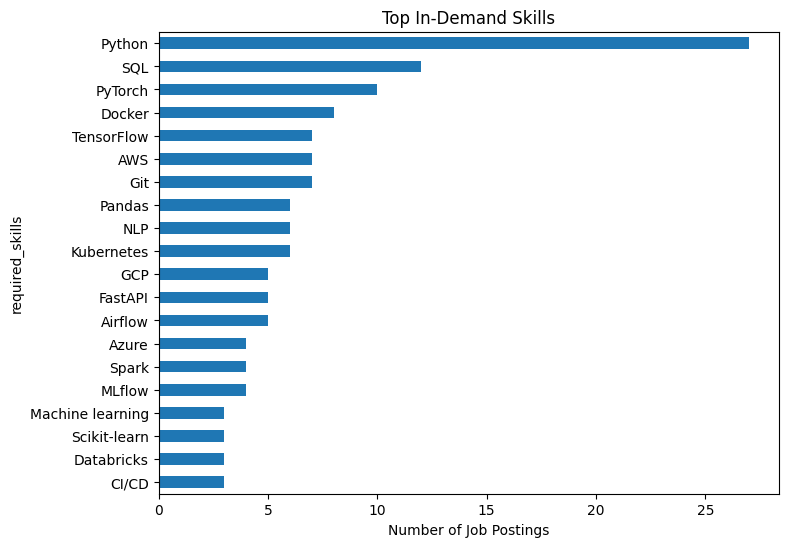

In [28]:
import matplotlib.pyplot as plt

top_skills.plot(kind="barh", figsize=(8, 6))
plt.title("Top In-Demand Skills")
plt.xlabel("Number of Job Postings")
plt.gca().invert_yaxis()
plt.show()


In [29]:
skills_time = (
    skills_df
    .groupby([pd.Grouper(key="scraped_at", freq="W"), "required_skills"])
    .size()
    .reset_index(name="count")
)


In [30]:
top_skill_names = top_skills.index.tolist()

skills_time = skills_time[
    skills_time["required_skills"].isin(top_skill_names)
]


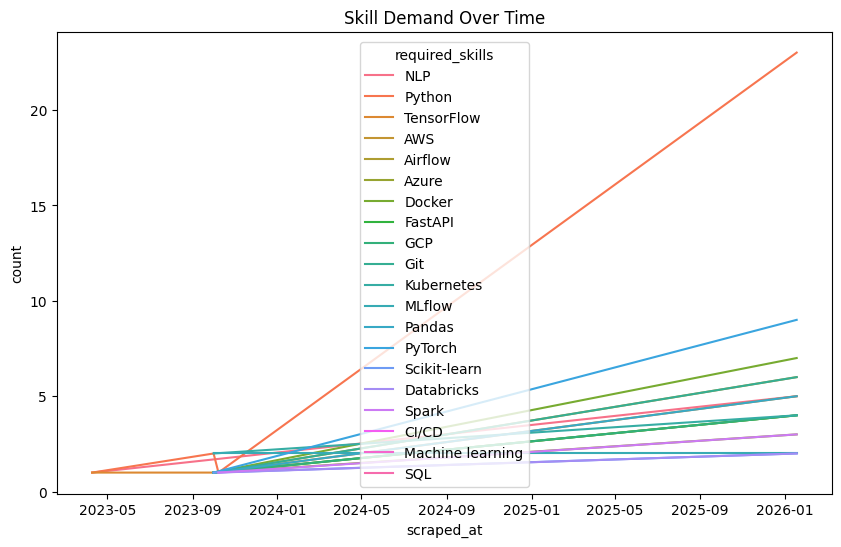

In [31]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=skills_time,
    x="scraped_at",
    y="count",
    hue="required_skills"
)
plt.title("Skill Demand Over Time")
plt.show()


In [32]:
df["role_normalized"] = (
    df["role"]
    .str.lower()
    .str.replace(r"\(.*?\)", "", regex=True)
    .str.strip()
)


In [33]:
df["role_normalized"].value_counts().head(15)


,count
role_normalized,
,10
machine learning engineer,6
data scientist,3
null,2
genai engineer,2
ai engineer,2
data scientist h/f,2
ml/ai engineer - monitoring,1
ai & machine learning engineer,1


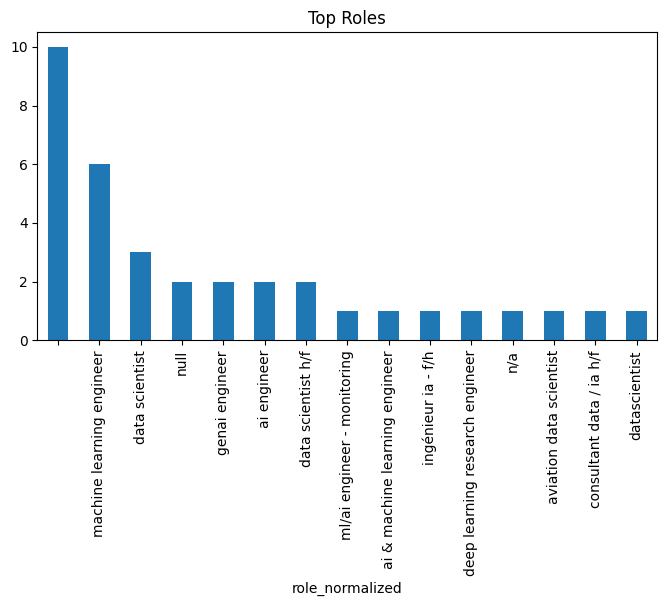

In [34]:
df["role_normalized"].value_counts().head(15).plot(
    kind="bar", figsize=(8, 4), title="Top Roles"
)
plt.show()


In [35]:
role_skill = (
    skills_df
    .assign(role=lambda d: d["role"].str.lower())
    .groupby(["role", "required_skills"])
    .size()
    .unstack(fill_value=0)
)

role_skill = role_skill.loc[
    role_skill.sum(axis=1).sort_values(ascending=False).head(10).index,
    role_skill.sum(axis=0).sort_values(ascending=False).head(15).index
]


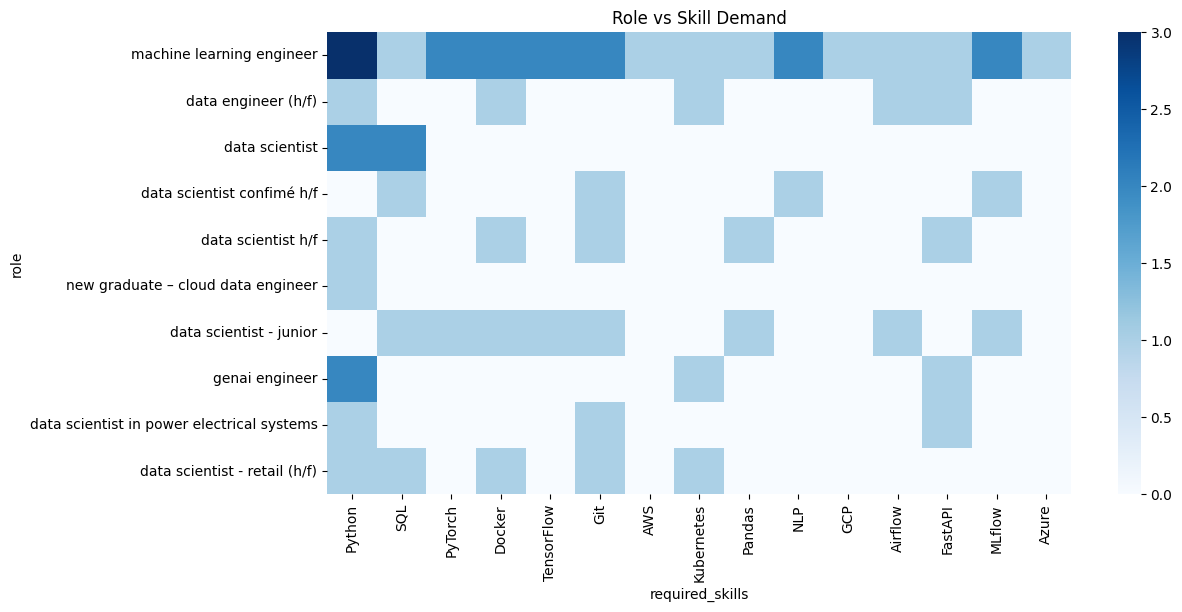

In [36]:
plt.figure(figsize=(12, 6))
sns.heatmap(role_skill, cmap="Blues")
plt.title("Role vs Skill Demand")
plt.show()


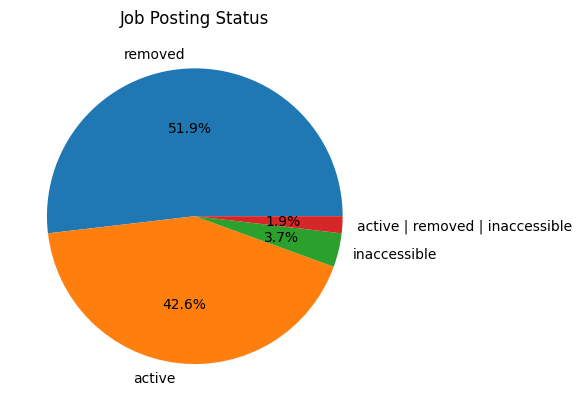

In [37]:
df["status"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", title="Job Posting Status"
)
plt.ylabel("")
plt.show()


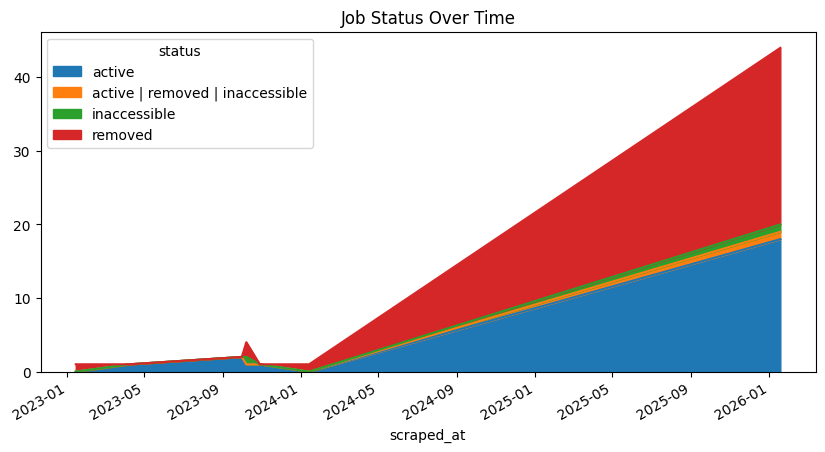

In [38]:
status_time = (
    df.groupby([pd.Grouper(key="scraped_at", freq="W"), "status"])
    .size()
    .unstack(fill_value=0)
)

status_time.plot.area(figsize=(10, 5))
plt.title("Job Status Over Time")
plt.show()


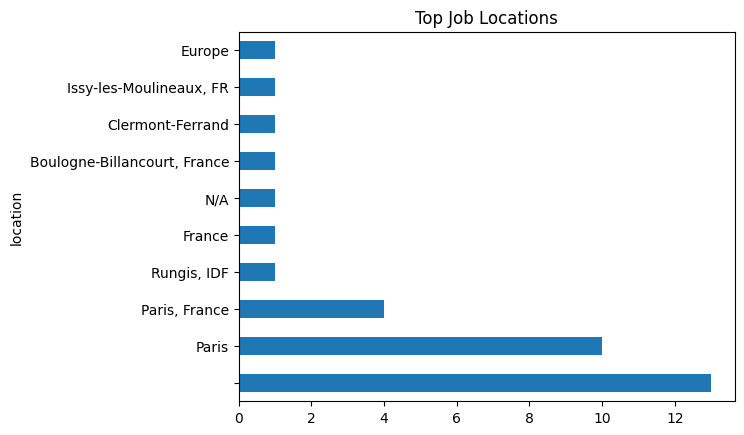

In [39]:
df["location"].value_counts().head(10).plot(
    kind="barh", title="Top Job Locations"
)
plt.show()


In [40]:
!pip install pandas numpy streamlit plotly rapidfuzz deep-translator scikit-learn -q

In [41]:
from deep_translator import GoogleTranslator

translator = GoogleTranslator(source="auto", target="en")

def safe_translate(text):
    if not text or not isinstance(text, str):
        return text
    try:
        return translator.translate(text)
    except Exception:
        return text

TEXT_COLUMNS = ["role", "required_experience", "location", "description"]

for col in TEXT_COLUMNS:
    df[col] = df[col].apply(safe_translate)

df["required_skills"] = df["required_skills"].apply(
    lambda skills: [safe_translate(s) for s in skills]
)


In [42]:
ROLE_MAP = {
    "ai engineer": "AI Engineer",
    "artificial intelligence engineer": "AI Engineer",
    "ia engineer": "AI engineer",
    "genai engineer": "AI engineer",
    "machine learning engineer": "Machine Learning Engineer",
    "ml engineer": "Machine Learning Engineer",
    "data scientist": "Data Scientist",
    "datascientist": "Data Scientist",
    "data science": "Data Scientist",
    "data engineer": "Data Engineer",
    "data analyst": "Data Analyst",
    "data architect": "Data Architect",
}


In [43]:
import re

def normalize_role(role):
    if role == "Null" or role == "N/A" or role == "Unknown" or not role:
        return "N/A"
    r = role.lower()
    r = re.sub(r"\(.*?\)", "", r).strip()
    for k, v in ROLE_MAP.items():
        if k in r:
            return v
    return role.title()

df["role_normalized"] = df["role"].apply(normalize_role)


In [81]:
import re

def normalize_role(role: str) -> str:
    if not role or not isinstance(role, str):
        return "N/A"

    r = role.lower()
    if role == "null" or role == "n/a" or role == "n a" or role == "unknown":
        return "N/A"

    # --------------------------------------------------
    # 1. Remove common noise / legal markers
    # --------------------------------------------------
    NOISE_PATTERNS = [
        r"\bh\/f\b",
        r"\bf\/h\b",
        r"\bconsultant\b",
        r"\bresearch\b",
        r"\bjunior\b",
        r"\bsenior\b",
        r"\bmid\b",
        r"\bmanager\b",
        r"\bhead\b",
    ]

    for pattern in NOISE_PATTERNS:
        r = re.sub(pattern, "", r)

    # --------------------------------------------------
    # 2. Remove punctuation & extra spaces
    # --------------------------------------------------
    r = re.sub(r"[()\-_/]", " ", r)
    r = re.sub(r"\s+", " ", r).strip()

    # --------------------------------------------------
    # 3. Semantic role detection (keyword-based)
    # --------------------------------------------------

    # AI roles
    if re.search(r"\bgenai\b|\bai\b|\bartificial intelligence\b", r):
        return "AI Engineer"

    # Machine Learning roles
    if re.search(r"\bmachine learning\b|\bml\b", r):
        return "Machine Learning Engineer"

    # Data Scientist roles
    if re.search(r"\bdata *scientist\b|\bdata ia\b", r):
        return "Data Scientist"

    # Data Engineer roles
    if re.search(r"\bdata engineer\b", r):
        return "Data Engineer"

    # Software Engineer roles
    if re.search(r"\bsoftware engineer\b|\bsoftware developer\b", r):
        return "Software Engineer"

    return r.title()


In [82]:
df["role_normalized"] = df["role"].apply(normalize_role)

In [83]:
df["role_normalized"].value_counts()

,count
role_normalized,
Data Scientist,15
N/A,13
AI Engineer,12
Machine Learning Engineer,7
Data Engineer,2
N A,1
Deep Learning Engineer,1
Spontaneous Application,1
Software Engineer,1


In [84]:
SKILL_MAP = {
    "python": ["python"],
    "docker": ["docker", "container", "containers", "containerization"],
    "kubernetes": ["kubernetes", "k8s"],
    "machine learning": ["machine learning", "ml"],
    "deep learning": ["deep learning", "dl"],
    "tensorflow": ["tensorflow", "tf"],
    "pytorch": ["pytorch", "torch"],
    "cloud": ["cloud computing", "aws", "gcp", "azure"],
}

from rapidfuzz import fuzz

def normalize_skill(skill):
    s = skill.lower().strip()
    for canonical, variants in SKILL_MAP.items():
        for v in variants:
            if fuzz.partial_ratio(s, v) > 85:
                return canonical
    return s

df["skills_normalized"] = df["required_skills"].apply(
    lambda skills: sorted(set(normalize_skill(s) for s in skills))
)


In [86]:
def classify_experience(text):
    if not text:
        return "Unspecified"
    t = text.lower()
    if any(x in t for x in ["junior", "<1", "<2", "<3", "1 year", "2 years"]):
        return "<3 years"
    if any(x in t for x in ["3", "4", "mid"]):
        return "3–5 years"
    if any(x in t for x in ["5", "senior", "lead", "principal"]):
        return ">5 years"
    return "Unspecified"

df["experience_level"] = df["required_experience"].apply(classify_experience)


In [87]:
skills_df = df.explode("skills_normalized")
skills_df = skills_df[skills_df["skills_normalized"].notna()]
skills_df.head()

,job_id,company,role,required_experience,required_skills,job_keywords,location,employment_type,description,source_url,status,scraped_at,role_normalized,skills_normalized,experience_level
1,R00133576,AbbVie,AI & Machine Learning Engineer,,"[Python, TensorFlow, Machine learning, AI solu...",[],"Rungis, IDF",Full-time,Model Deployment: deploy machine learning mode...,https://careers.abbvie.com/en/job/ai-and-machi...,removed,2026-01-12 01:48:32.578225+00:00,AI Engineer,ai solutions,Unspecified
1,R00133576,AbbVie,AI & Machine Learning Engineer,,"[Python, TensorFlow, Machine learning, AI solu...",[],"Rungis, IDF",Full-time,Model Deployment: deploy machine learning mode...,https://careers.abbvie.com/en/job/ai-and-machi...,removed,2026-01-12 01:48:32.578225+00:00,AI Engineer,big data,Unspecified
1,R00133576,AbbVie,AI & Machine Learning Engineer,,"[Python, TensorFlow, Machine learning, AI solu...",[],"Rungis, IDF",Full-time,Model Deployment: deploy machine learning mode...,https://careers.abbvie.com/en/job/ai-and-machi...,removed,2026-01-12 01:48:32.578225+00:00,AI Engineer,cloud,Unspecified
1,R00133576,AbbVie,AI & Machine Learning Engineer,,"[Python, TensorFlow, Machine learning, AI solu...",[],"Rungis, IDF",Full-time,Model Deployment: deploy machine learning mode...,https://careers.abbvie.com/en/job/ai-and-machi...,removed,2026-01-12 01:48:32.578225+00:00,AI Engineer,docker,Unspecified
1,R00133576,AbbVie,AI & Machine Learning Engineer,,"[Python, TensorFlow, Machine learning, AI solu...",[],"Rungis, IDF",Full-time,Model Deployment: deploy machine learning mode...,https://careers.abbvie.com/en/job/ai-and-machi...,removed,2026-01-12 01:48:32.578225+00:00,AI Engineer,kalman filter,Unspecified


In [88]:
normalized_jobs = df[["role_normalized","skills_normalized", "experience_level"]]
normalized_jobs.columns = ["role", "required_skills", "required_experience"]

In [94]:
!pip install streamlit cloudflared


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 2.3 MB/s eta 0:00:00
  Created wheel for cloudflared: filename=cloudflared-1.0.0.2-py3-none-any.whl size=2983 sha256=95b56210b1e3c3c141e957b04af7b77f001f2a191fc66b0629c4aa9a0d4bfd79
  Stored in directory: /root/.cache/pip/wheels/5b/ec/09/c3bcd3470be046ec77a9c0cb9d8bb6ceed49c831460878ab0a
Successfully built cloudflared


In [125]:
%%writefile app.py
import streamlit as st
import plotly.express as px
import pandas as pd

st.set_page_config(layout="wide")
st.title("Job Market Skill Intelligence Dashboard")

df = pd.read_csv("jobs_normalized.csv")

roles = st.multiselect(
    "Role",
    df["role"].unique(),
    default=df["role"].unique()
)

filtered = df[df["role"].isin(roles)]

skills_df = filtered.explode("required_skills")

skill_counts = (
    skills_df["required_skills"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Skill", "required_skills": "Count"})
)
st.write(skill_counts)

fig = px.bar(
    skill_counts.head(20),
    x="Count",
    y="Skill",
    orientation="h",
    title="Top Required Skills"
)

st.plotly_chart(fig, use_container_width=True)


Overwriting app.py


In [89]:
# import json

# with open("jobs_normalized.json", "w") as f:
#     json.dump(normalized_jobs, f)
normalized_jobs.to_csv('jobs_normalized.csv', index=False)

In [127]:
!streamlit run app.py &>/content/streamlit.log &


In [126]:
!pkill -f streamlit


In [107]:
%%bash
wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
chmod +x cloudflared-linux-amd64
mv cloudflared-linux-amd64 /usr/local/bin/cloudflared


In [108]:
!cloudflared --version


cloudflared version 2025.11.1 (built 2025-11-07-16:59 UTC)


In [129]:
!cloudflared tunnel --url http://localhost:8501


2026-01-12T02:43:38Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-01-12T02:43:38Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-01-12T02:43:42Z INF +--------------------------------------------------------------------------------------------+
2026-01-12T02:43:42Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2026-01-12T02:43:42Z INF |  https://reprints-glossary-judges-neon.trycloudflare.c